#**Task 01 Weather Forecasting**

You are a data scientist working for a smart agriculture startup. Farmers rely on accurate
weather predictions to plan irrigation, planting, and harvesting. However, traditional weather
forecasts are not always reliable for hyper-local conditions. Your task is to build a machine
learning model that predicts whether it will rain or not based on historical weather data. <br>

This
data has been manually entered into an Excel sheet, but there are some mistakes, such as
missing values, incorrect entries, and formatting inconsistencies, which need to be cleaned and
processed before training the model.
The dataset provided contains daily weather observations for 300 days, including:

● avg_temperature: Average temperature in °C <br>
● humidity: Humidity in percentage <br>
● avg_wind_speed: Average wind speed in km/h <br>
● rain_or_not: Binary label (1 = rain, 0 = no rain)<br>
● date: Date of observation

Your goal is to predict the `rain_or_not` label for future 21 days based on the given features.
Part - 1 - 85%
Participants are expected to:
1. Preprocess the dataset (e.g., handle missing values, encode features, etc.). - 20%
2. Perform exploratory data analysis (EDA) to understand relationships between features and
the target variable. - 30%
3. Train and evaluate machine learning models (e.g., logistic regression, decision trees, random
forests, gradient boosting, etc.). - 20 %
4. Optimize the model using hyperparameter tuning and feature engineering. -10%
5. final output should able to provide the probability of rain - 5%



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


Loading the data

In [3]:
# !wget -O weather_data.csv "https://raw.githubusercontent.com/subhanu-dev/Agri-timeseries/refs/heads/main/weather_data.csv"

In [4]:
df = pd.read_csv("weather_data.csv",parse_dates=['date'])
df.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331


# Preprocessing and EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             311 non-null    datetime64[ns]
 1   avg_temperature  296 non-null    float64       
 2   humidity         296 non-null    float64       
 3   avg_wind_speed   296 non-null    float64       
 4   rain_or_not      311 non-null    object        
 5   cloud_cover      296 non-null    float64       
 6   pressure         311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.1+ KB


In [6]:
df.shape

(311, 7)

311 rows of data for 300 days of data means that there could be incorrect or  or duplicate entries

In [7]:
print("Unique values in rain_or_not:", df['rain_or_not'].unique())
print("Null values: ",df['rain_or_not'].isna().sum())

Unique values in rain_or_not: ['Rain' 'No Rain']
Null values:  0


In [8]:
df['rain_or_not'] = df['rain_or_not'].map({'Rain': 1, 'No Rain': 0}) # Replacing Rain with 1 and no rain with 0
df['rain_or_not'] = pd.to_numeric(df['rain_or_not']) # changing the data type to numeric (int)

In [9]:
df.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,1,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,1,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,1,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,1,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,1,38.062329,1030.264331


In [10]:
df.tail()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
306,2023-11-03,22.072834,37.756910,4.729355,0,27.307081,954.564875
307,2023-11-04,19.645885,42.190604,8.092369,0,51.807877,964.002410
308,2023-11-05,23.884496,36.205508,11.860847,1,29.872557,977.681431
309,2023-11-06,18.168418,34.785000,4.781288,0,94.067925,1047.153269
310,2023-11-07,19.389714,37.717416,9.388371,0,25.929676,983.134701


Removing dupllicate values

In [11]:
# seeing if the dates were duplicated
duplicate_dates = df['date'].duplicated().sum()
print(f"Number of duplicate dates: {duplicate_dates}")

Number of duplicate dates: 0


In [12]:
print(df.duplicated().sum()) # no rows in the dataset are exact duplicates

0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             311 non-null    datetime64[ns]
 1   avg_temperature  296 non-null    float64       
 2   humidity         296 non-null    float64       
 3   avg_wind_speed   296 non-null    float64       
 4   rain_or_not      311 non-null    int64         
 5   cloud_cover      296 non-null    float64       
 6   pressure         311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 17.1 KB


In [14]:
df.describe()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
count,311,296.000000,296.000000,296.000000,311.000000,296.000000,311.000000
mean,2023-06-05 00:00:00,25.983840,55.041385,7.556636,0.636656,49.834827,1001.059119
min,2023-01-01 00:00:00,15.000000,30.000000,0.069480,0.000000,0.321826,951.240404
25%,2023-03-19 12:00:00,20.265692,34.280826,3.550354,0.000000,24.530951,975.757545
50%,2023-06-05 00:00:00,27.177958,56.759806,7.326421,1.000000,50.725120,1001.938586
75%,2023-08-21 12:00:00,32.204599,72.189837,11.050627,1.000000,76.046506,1026.578884
max,2023-11-07 00:00:00,35.000000,90.000000,56.636041,1.000000,99.834751,1049.543752
std,NaN,6.802475,19.220133,5.344683,0.481738,29.009459,28.835595


Since date, rain_or_not, and pressure have 311 non-null values, while avg_temperature, humidity, avg_wind_speed, and cloud_cover have only 296 non-null values, we’re dealing with 15 rows where some features are missing.

The 15 rows with missing values in avg_temperature, humidity, avg_wind_speed, and cloud_cover likely align, meaning entire records are incomplete except for date, rain_or_not, and pressure.

In [15]:
missing_mask = df[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']].isnull().any(axis=1)
missing_rows = df[missing_mask]
print("Rows with missing values (15 rows expected):")
missing_rows

Rows with missing values (15 rows expected):


,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
12,2023-01-13,NaN,NaN,NaN,0,NaN,1022.950823
15,2023-01-16,NaN,NaN,NaN,1,NaN,1011.022515
16,2023-01-17,NaN,NaN,NaN,0,NaN,963.535408
44,2023-02-14,NaN,NaN,NaN,1,NaN,1006.016818
47,2023-02-17,NaN,NaN,NaN,1,NaN,991.879332
52,2023-02-22,NaN,NaN,NaN,0,NaN,1015.417460
57,2023-02-27,NaN,NaN,NaN,1,NaN,1010.852727
71,2023-03-13,NaN,NaN,NaN,0,NaN,1004.353822
111,2023-04-22,NaN,NaN,NaN,1,NaN,1032.210316
114,2023-04-25,NaN,NaN,NaN,1,NaN,1046.447665


Span from January 13, 2023, to October 30, 2023 (~10 months), suggesting daily data with occasional missing entries.

311 days is a relatively small dataset for a time series task, so losing 15 rows (about 4.8%) could impact model performance, especially if those rows are consecutive (e.g., a gap in the time series)

Dropping 15 rows could create gaps that disrupt lagged and rolling features, which are essential for capturing temporal dependencies. Thus our option we are left with here is imputing these missing data.

Interpolation works well for weather data, as temperature, humidity, wind speed, and cloud cover tend to change gradually.

In [16]:
df.set_index('date', inplace=True) # resetting index

In [17]:
# Columns with missing values
columns_with_nans = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']

#  Summary Statistics Before Imputation
df[columns_with_nans].describe()

,avg_temperature,humidity,avg_wind_speed,cloud_cover
count,296.000000,296.000000,296.000000,296.000000
mean,25.983840,55.041385,7.556636,49.834827
std,6.802475,19.220133,5.344683,29.009459
min,15.000000,30.000000,0.069480,0.321826
25%,20.265692,34.280826,3.550354,24.530951
50%,27.177958,56.759806,7.326421,50.725120
75%,32.204599,72.189837,11.050627,76.046506
max,35.000000,90.000000,56.636041,99.834751


In [18]:
# interpolate missing values
df_interpolated = df.interpolate(method='time')

In [19]:
df_interpolated[columns_with_nans].describe() # data distribution after imputation

,avg_temperature,humidity,avg_wind_speed,cloud_cover
count,311.000000,311.000000,311.000000,311.000000
mean,26.068008,55.182861,7.524979,49.889761
std,6.761455,19.040509,5.250637,28.549246
min,15.000000,30.000000,0.069480,0.321826
25%,20.339312,35.385720,3.688134,25.698369
50%,27.209049,57.379765,7.140756,50.489334
75%,32.218213,72.005056,10.985977,75.155755
max,35.000000,90.000000,56.636041,99.834751


Thus the imputation has been done without impacting the data distribution patterns with time interpolation.

In [20]:
df_interpolated.head()

,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
date,,,,,,
2023-01-01,23.745401,46.140905,7.845981,1,20.851051,992.965681
2023-01-02,30.030503,59.876587,5.382457,1,93.059521,1037.273025
2023-01-03,28.365224,51.464618,13.158008,1,11.636640,1034.193357
2023-01-04,27.550929,53.103799,5.886677,1,81.744971,968.610142
2023-01-05,23.639303,57.826186,12.248992,1,38.062329,1030.264331


Checking if the dates are consecutive to avoid rendering blanks in plots

In [21]:
date_series = df_interpolated.index
print("Using index as date series")


# Calculate differences in days
date_diffs = date_series.to_series().diff().dt.days.dropna()
print("Date differences (should be 1 for consecutive days):", date_diffs.unique())

# Find missing dates
expected_dates = pd.date_range(start=date_series.min(), end=date_series.max(), freq='D')
missing_dates = expected_dates[~expected_dates.isin(date_series)]
print("Number of missing dates:", len(missing_dates))
if len(missing_dates) > 0:
    print("Missing dates:\n", missing_dates)
else:
    print("No missing dates found.")

Using index as date series
Date differences (should be 1 for consecutive days): [1.]
Number of missing dates: 0
No missing dates found.


## Time series plots

Index type: datetime64[ns]


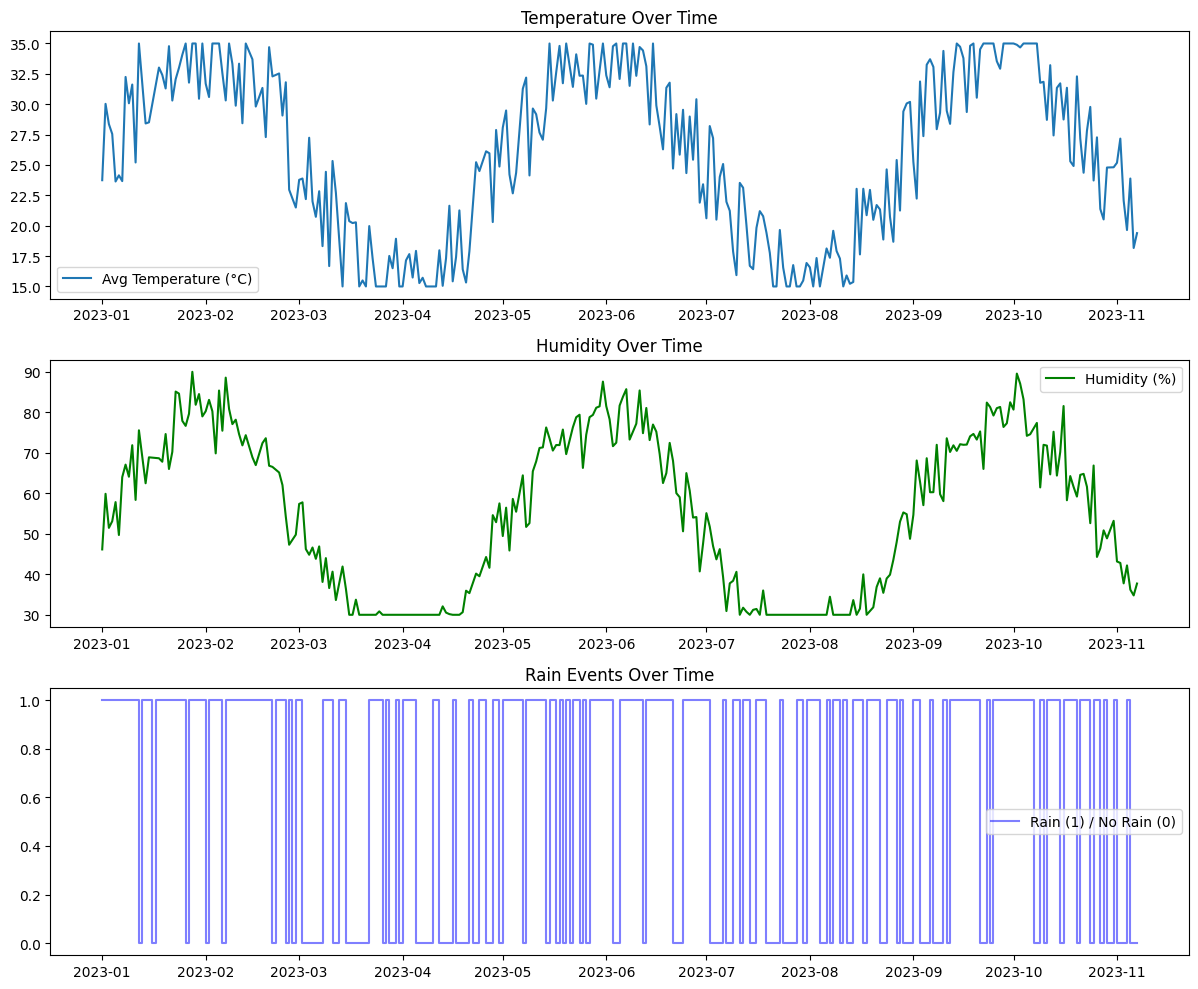

In [22]:
print("Index type:", df.index.dtype)
# Time Series Plots
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(df.index, df_interpolated['avg_temperature'], label='Avg Temperature (°C)')
plt.title('Temperature Over Time')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df.index, df_interpolated['humidity'], label='Humidity (%)', color='green')
plt.title('Humidity Over Time')
plt.legend()

plt.subplot(3, 1, 3)
plt.step(df.index, df_interpolated['rain_or_not'], label='Rain (1) / No Rain (0)', color='blue', alpha=0.5)
plt.title('Rain Events Over Time')
plt.legend()

plt.tight_layout()
plt.show()

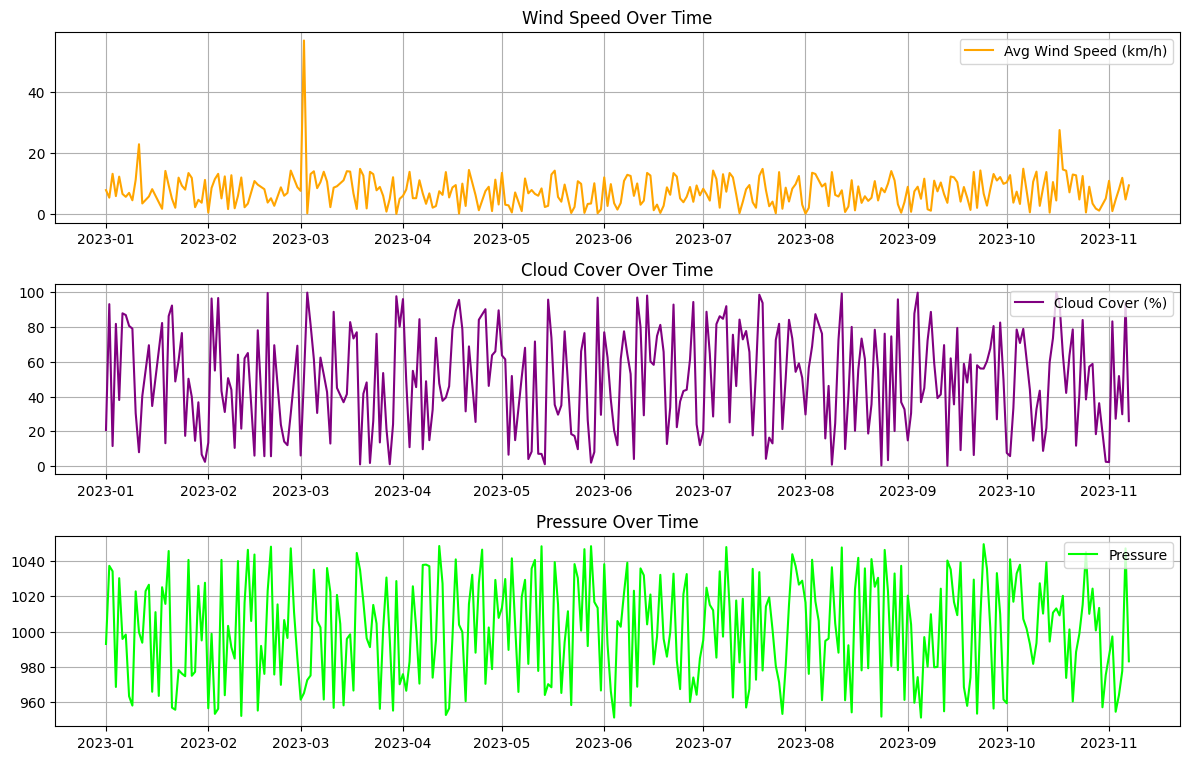

In [23]:
plt.figure(figsize=(12, 10))  # Adjusted figure size

# Wind Speed
plt.subplot(4, 1, 2)  # Adjusting subplot position
plt.plot(df_interpolated.index, df_interpolated['avg_wind_speed'], label='Avg Wind Speed (km/h)', color='orange')
plt.title('Wind Speed Over Time')
plt.legend()
plt.grid(True)

# Cloud Cover
plt.subplot(4, 1, 3)  # Adjusting subplot position
plt.plot(df_interpolated.index, df_interpolated['cloud_cover'], label='Cloud Cover (%)', color='purple')
plt.title('Cloud Cover Over Time')
plt.legend()
plt.grid(True)

#pressure
plt.subplot(4, 1, 4)  # Adjusting subplot position
plt.plot(df_interpolated.index, df_interpolated['pressure'], label='Pressure', color='lime')
plt.title('Pressure Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Prevent overlapping
plt.show()


**Temperature**

The temperature shows a clear seasonal pattern, peaking around June-July (summer) at approximately 30-35°C, and dipping to 15-20°C in January-February and October-November (winter).
There’s daily variability (jagged lines), reflecting typical weather fluctuations.

**Humidity**

Humidity fluctuates between 30% and 80%, with higher values (60-80%) in the earlier months (Jan-Mar) and later months (Oct-Nov), possibly indicating wetter periods.
A noticeable dip occurs around April-May (30-40%), coinciding with the temperature peak, suggesting drier conditions in summer.



**Wind Speed**

Wind speed fluctuates mostly between 0 and 15 km/h, with a mean of 7.52 km/h (from summary stats). This aligns with the 25th to 75th percentile range (3.69 to 10.99 km/h). there's an irregular increase in windspeed around march with a windspeed of 56km/h

**Cloud Cover**

Cloud cover varies widely between 0% and 100%, with a mean of 49.89% (from summary stats). It oscillates frequently, reflecting changing weather patterns.
High Cloud Cover Periods: Peaks (>80%) occur in:

    January-February
    Late April to May
    October-November

Low Cloud Cover Periods: Dips (<20%) are seen in:

    March-April
    June-July
    September

cloud cover shows high daily variability, with rapid shifts from clear to overcast conditions.

High cloud cover (>80%) in Jan-Feb, Apr-May, and Oct-Nov often coincides with rain events. This suggests cloud cover is a strong predictor of rain.

Humidity: Similarly, high humidity periods (Jan-Mar, Oct-Nov) align with rain, reinforcing humidity’s predictive power.

Wind Speed: The wind speed spike in late february (~50 km/h)  could either be an outlier or it should correspond to a rainy season

### Looking in to the wind speed spike

In [24]:
max_wind_speed_date = df_interpolated['avg_wind_speed'].idxmax()
print(max_wind_speed_date)

2023-03-02 00:00:00


In [25]:
wind_spike_period = df_interpolated.loc['2023-02-25':'2023-03-05']
print("Data around wind speed spike:\n", wind_spike_period[['avg_wind_speed', 'rain_or_not', 'cloud_cover', 'humidity']])

Data around wind speed spike:
             avg_wind_speed  rain_or_not  cloud_cover   humidity
date                                                           
2023-02-25        6.930087            1    12.138494  54.213932
2023-02-26       14.209250            0    30.327515  47.298993
2023-02-27       11.501349            1    49.771824  48.544416
2023-02-28        8.793447            0    69.216134  49.789840
2023-03-01        7.588330            1     6.229180  57.379765
2023-03-02       56.636041            1    50.942213  57.764299
2023-03-03        0.271653            0    99.669685  46.232332
2023-03-04       13.081859            0    81.397027  44.824569
2023-03-05       13.981774            0    61.521944  46.615081


from 7.59 km/h on Mar 1 to 56.64 km/h on Mar 2, then drops sharply to 0.27 km/h on Mar 3. This sudden change suggests either a significant weather event or a potential data anomaly.

Nearby days also have rain (Feb 25, Feb 27, Mar 1), but not immediately before or after the spike (Feb 26, Feb 28, Mar 3-5 are 0).
Rain on Mar 2 supports the idea of a stormy day, which could explain high wind speed.

Humidity on Mar 2 is 57.76%, which is moderate (mean humidity is 55.18%, max is 90%). It’s slightly higher than surrounding days but not extreme.

The jump from 7.59 km/h to 56.64 km/h and back to 0.27 km/h in one day each way is suspicious. Weather changes can be sudden, but this is extreme.

Mean avg_wind_speed:     7.52 km/h <br>
    75th percentile: 10.99 km/h <br>
    Max: 56.64 km/h

The spike is over 5 standard deviations above the mean (std = 5.25 km/h), making it statistically an outlier.

also when looking at other features alongside this <br>
Cloud cover (50.94%) isn’t at its peak (max is 99.83%). <br>
Humidity (57.76%) isn’t unusually high (max is 90%). <br>
While it’s a rainy day, nearby rainy days (e.g., Mar 1) don’t show similar wind speeds.

Thus it's safe to assume that this is potential data entry error.

In [26]:
df_cleaned = df_interpolated.copy()

In [27]:
# Calculate the 99th percentile
wind_99th = df_interpolated['avg_wind_speed'].quantile(0.99)
print("99th percentile of wind speed:", wind_99th)


99th percentile of wind speed: 14.810779906398237


In [28]:
# Cap the outlier
df_cleaned['avg_wind_speed'] = df_interpolated['avg_wind_speed'].clip(upper=wind_99th)

# Verify
print("Data around wind speed spike after capping:\n",
      df_cleaned.loc['2023-02-25':'2023-03-05'][['avg_wind_speed', 'rain_or_not', 'cloud_cover', 'humidity']])

Data around wind speed spike after capping:
             avg_wind_speed  rain_or_not  cloud_cover   humidity
date                                                           
2023-02-25        6.930087            1    12.138494  54.213932
2023-02-26       14.209250            0    30.327515  47.298993
2023-02-27       11.501349            1    49.771824  48.544416
2023-02-28        8.793447            0    69.216134  49.789840
2023-03-01        7.588330            1     6.229180  57.379765
2023-03-02       14.810780            1    50.942213  57.764299
2023-03-03        0.271653            0    99.669685  46.232332
2023-03-04       13.081859            0    81.397027  44.824569
2023-03-05       13.981774            0    61.521944  46.615081


Thus the wind speed on the 2nd of March has been capped to the maximum 99th percentile to avoid it causing the overall dataset's distribution to change.Also it's been set to the largest value available (99th percentile) in the entire distribution to preserve its high value.  

## Distributions of each feature



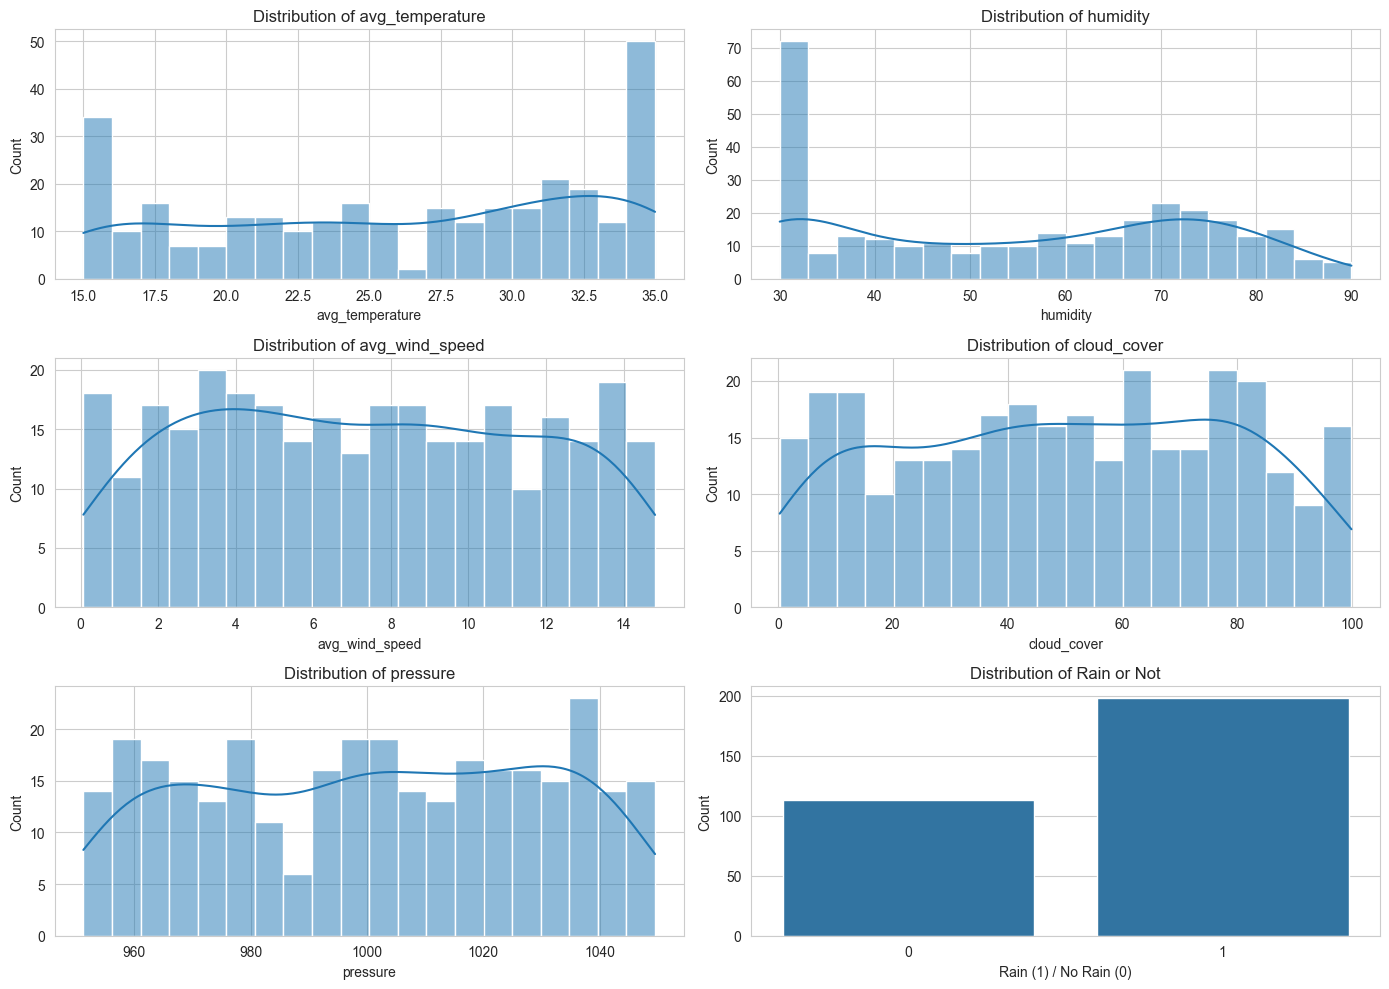

In [29]:
sns.set_style("whitegrid")

# Create figure with subplots
plt.figure(figsize=(14, 10))

# List of continuous features
continuous_features = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']

# Plot histograms with KDE for continuous features
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=df_cleaned, x=feature, bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

# Plot count plot for rain_or_not (binary)
plt.subplot(3, 2, 6)
sns.countplot(data=df_cleaned, x='rain_or_not')
plt.title('Distribution of Rain or Not')
plt.xlabel('Rain (1) / No Rain (0)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

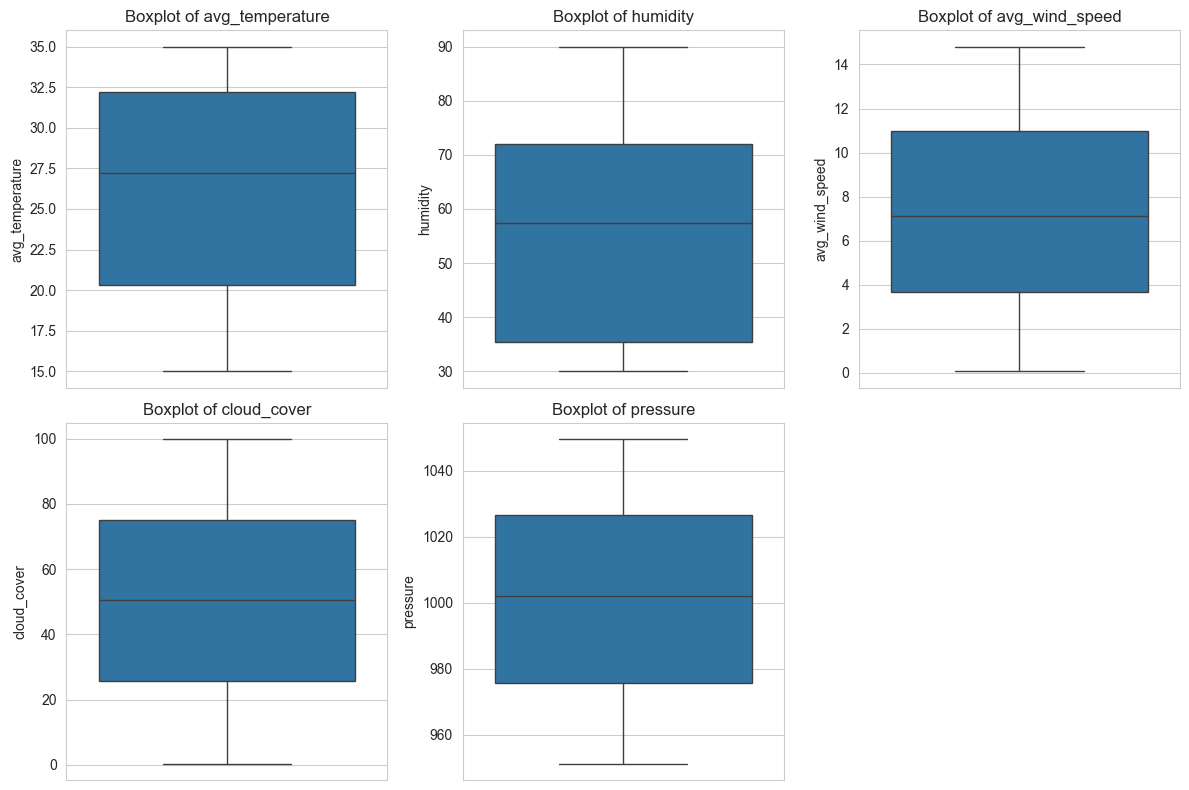

Summary Statistics for Features:
        avg_temperature    humidity  avg_wind_speed  cloud_cover     pressure
count       296.000000  296.000000      296.000000   296.000000   311.000000
mean         25.983840   55.041385        7.556636    49.834827  1001.059119
std           6.802475   19.220133        5.344683    29.009459    28.835595
min          15.000000   30.000000        0.069480     0.321826   951.240404
25%          20.265692   34.280826        3.550354    24.530951   975.757545
50%          27.177958   56.759806        7.326421    50.725120  1001.938586
75%          32.204599   72.189837       11.050627    76.046506  1026.578884
max          35.000000   90.000000       56.636041    99.834751  1049.543752


In [30]:
# distribution of each feature with boxplots

plt.figure(figsize=(12, 8))

# Plot individual boxplots for each feature
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df_cleaned, y=feature)
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

# Optional: Summary statistics for reference
print("Summary Statistics for Features:\n", df[continuous_features].describe())


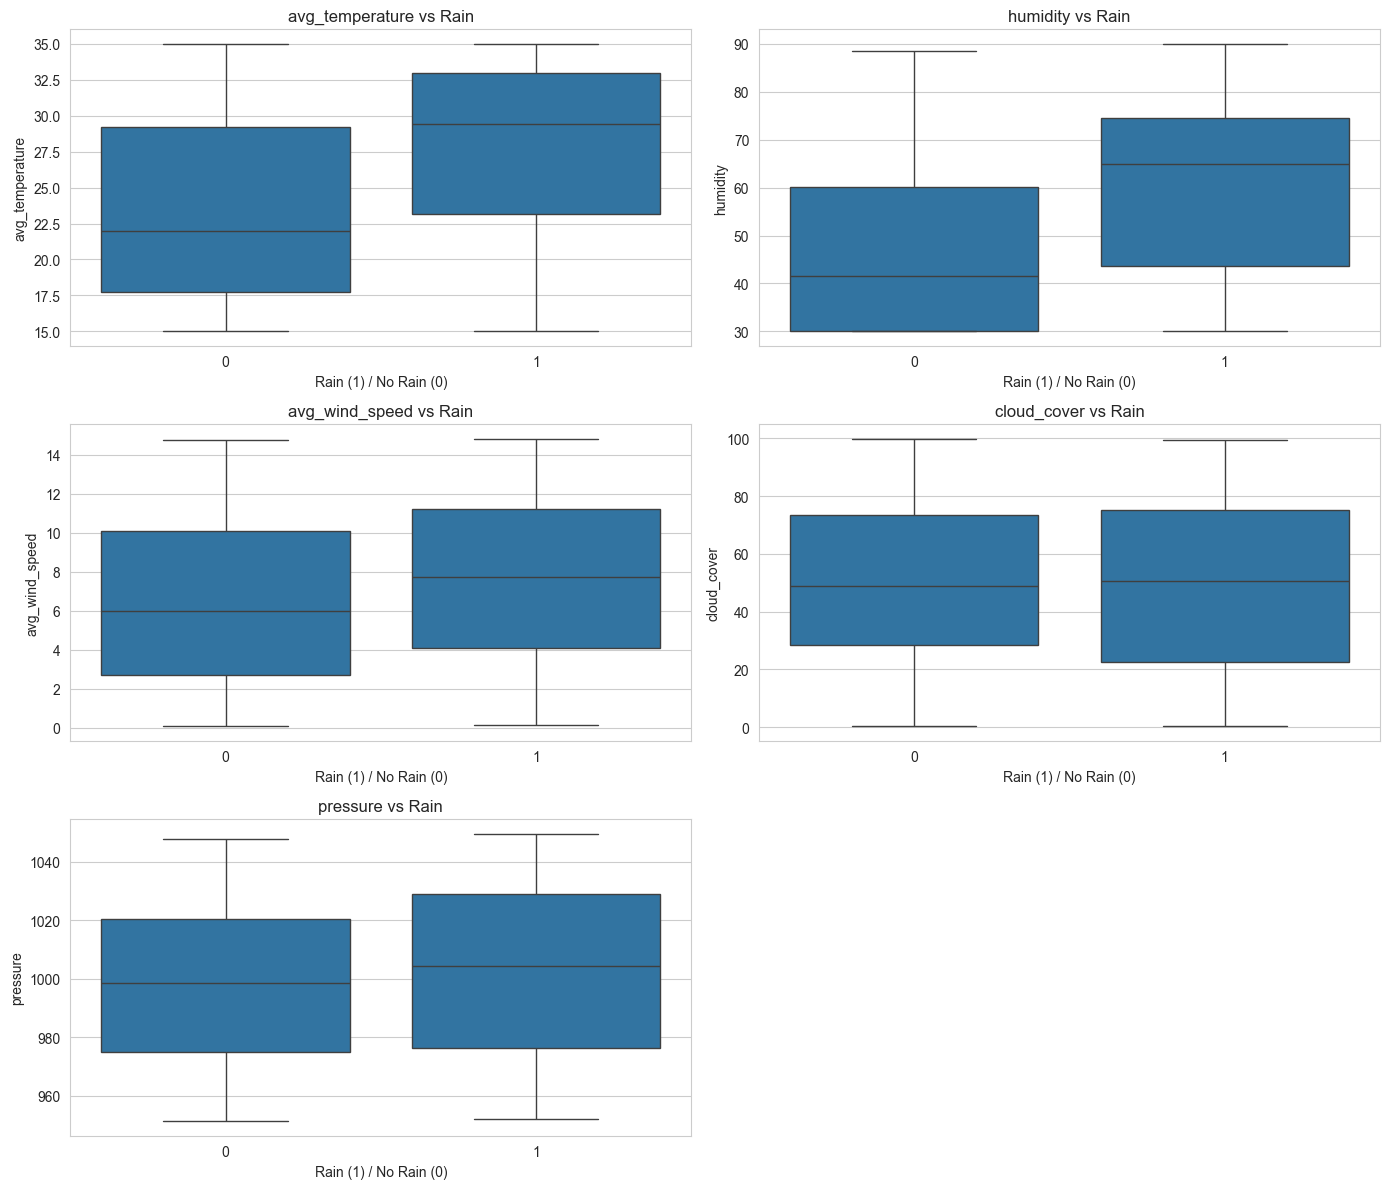

In [31]:
# Boxplots Grouped by rain_or_not
plt.figure(figsize=(14, 12))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df_cleaned, x='rain_or_not', y=feature)
    plt.title(f'{feature} vs Rain')
    plt.xlabel('Rain (1) / No Rain (0)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

Average_temperature and humidity are the main two features that show a clear difference in distribution between rain and no-rain circumstances.

Cloud cover shows a wider distribution and pressure and windspeed have slightly higher values in raining scenarios.

## Correlation analysis

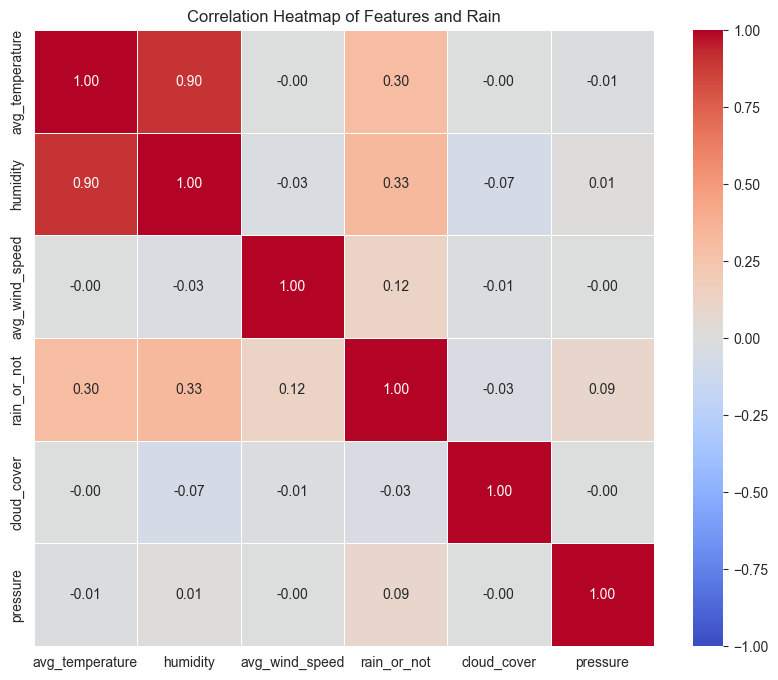

In [32]:
correlation_matrix = df_cleaned.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features and Rain')
plt.show()

In [33]:
# Print correlations with rain_or_not
print("Correlations with rain_or_not:\n", correlation_matrix['rain_or_not'].sort_values(ascending=False))

Correlations with rain_or_not:
 rain_or_not        1.000000
humidity           0.325372
avg_temperature    0.298929
avg_wind_speed     0.123089
pressure           0.090059
cloud_cover       -0.034943
Name: rain_or_not, dtype: float64


As observed in the distribution plot anaylsis with rain and no rain, we can see that humidy, average temperature and average wind speed in the order are the main factors causing rain

**Correlations between other features**

A correlation of 0.90 indicates a very strong linear relationship between avg_temperature and humidity. As temperature increases, humidity tends to increase, and vice versa. In meteorology, temperature and humidity are related through evaporation—higher temperatures increase evaporation, raising humidity until a saturation point is reached (e.g., dew point).

avg_wind_speed with others: Near-zero correlations (-0.00 to -0.03), suggesting wind speed is largely independent of temperature, humidity, and other features in this dataset.

pressure and cloud cover with others: Weak correlations indicating pressure doesn’t vary much with these features.


Autocorrelation

<Figure size 1200x600 with 0 Axes>

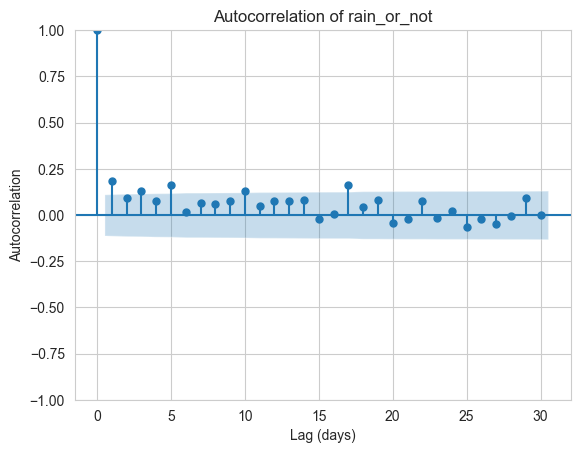

In [34]:
# Plot autocorrelation for rain_or_not
plt.figure(figsize=(12, 6))
plot_acf(df_cleaned['rain_or_not'], lags=30, alpha=0.05)  # 30 lags, 95% confidence interval
plt.title('Autocorrelation of rain_or_not')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

All autocorrelation values from lag 1 onward are within the confidence interval (between -0.11 and 0.11). This indicates that none of the autocorrelations are statistically significant at the 95% confidence level.

The values fluctuate around 0, with no clear pattern or spikes. There’s no evidence of weekly (lag 7) or monthly (lag 28-30) patterns, as all values remain insignificant.

The near-zero autocorrelation across all lags indicates that rain_or_not behaves almost like a random process in this dataset. Rain today doesn’t strongly predict rain tomorrow or at any other lag.

Rain events appear to be driven more by immediate weather conditions (e.g., humidity, cloud_cover, pressure) rather than past rain patterns. On the other hand, since we only have data for 311 days, using a feature based model can be better in this context.

*2025-03-17 the above conclusion was wrong:*

The standard autocorrelation function (plot_acf) assumes normally distributed continuous data.
For binary (categorical) data, the results might not be as informative

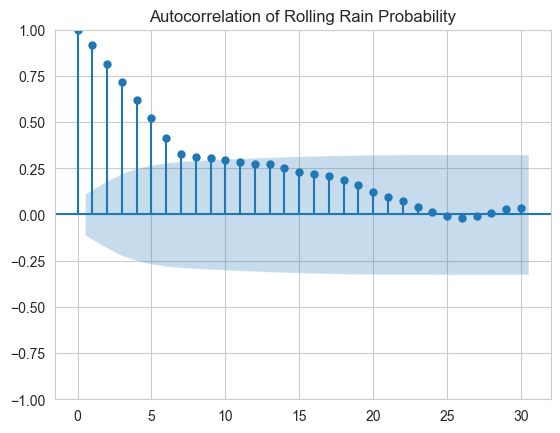

In [35]:
df_cleaned['rain_prob'] = df_cleaned['rain_or_not'].rolling(window=7, min_periods=1).mean()
plot_acf(df_cleaned['rain_prob'].dropna(), lags=30, alpha=0.05)
plt.title('Autocorrelation of Rolling Rain Probability')
plt.show()


In [36]:
df_cleaned['rain_prob']

date
2023-01-01    1.000000
2023-01-02    1.000000
2023-01-03    1.000000
2023-01-04    1.000000
2023-01-05    1.000000
                ...   
2023-11-03    0.285714
2023-11-04    0.285714
2023-11-05    0.285714
2023-11-06    0.285714
2023-11-07    0.285714
Name: rain_prob, Length: 311, dtype: float64

There is a strong short-term correlation in rainfall probability. If it has rained recently, it is more likely to rain again in the next few days.

**Runs Test (Wald-Wolfowitz Test)**

Checks for randomness in the sequence. If rain occurrence is dependent, the runs test will indicate non-randomness.

In [37]:
from statsmodels.sandbox.stats.runs import runstest_1samp
z, p_value = runstest_1samp(df_cleaned['rain_or_not'], correction=True)
print(f'Runs Test Z-score: {z}, p-value: {p_value}')


Runs Test Z-score: -3.3012612173857367, p-value: 0.0009625122477201222


P value below .5 means that the sequence is not random. indicating strong autocorrelations

In [38]:
df_cleaned.drop(columns='rain_prob', inplace=True)  # dropping the rain prob as it's redundant and a feature we won't have for the future predictions.

## Feature Engineering

In [39]:
#adding lagged and rolling features

df_engineered=df_cleaned.copy()

#  Add Lagged Features (1-day lag for all features)
df_engineered['humidity_lag1'] = df_engineered['humidity'].shift(1)
df_engineered['avg_wind_speed_lag1'] = df_engineered['avg_wind_speed'].shift(1)
df_engineered['cloud_cover_lag1'] = df_engineered['cloud_cover'].shift(1)
df_engineered['pressure_lag1'] = df_engineered['pressure'].shift(1)

#not adding a lagged feature / Rolling feature for temperature as it's redundant with humidity. if added both they might introducce heavier bias towards the majority class instances.


In [40]:
df_engineered.head()

,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure,humidity_lag1,avg_wind_speed_lag1,cloud_cover_lag1,pressure_lag1
date,,,,,,,,,,
2023-01-01,23.745401,46.140905,7.845981,1,20.851051,992.965681,NaN,NaN,NaN,NaN
2023-01-02,30.030503,59.876587,5.382457,1,93.059521,1037.273025,46.140905,7.845981,20.851051,992.965681
2023-01-03,28.365224,51.464618,13.158008,1,11.636640,1034.193357,59.876587,5.382457,93.059521,1037.273025
2023-01-04,27.550929,53.103799,5.886677,1,81.744971,968.610142,51.464618,13.158008,11.636640,1034.193357
2023-01-05,23.639303,57.826186,12.248992,1,38.062329,1030.264331,53.103799,5.886677,81.744971,968.610142


In [41]:
#Rolling features
df_engineered['humidity_roll7'] = df_engineered['humidity'].rolling(window=7).mean()
df_engineered['avg_wind_speed_roll7'] = df_engineered['avg_wind_speed'].rolling(window=7).mean()
df_engineered['cloud_cover_roll7'] = df_engineered['cloud_cover'].rolling(window=7).mean()
df_engineered['pressure_roll7'] = df_engineered['pressure'].rolling(window=7).mean()

In [42]:
df_engineered.head(10)

,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure,humidity_lag1,avg_wind_speed_lag1,cloud_cover_lag1,pressure_lag1,humidity_roll7,avg_wind_speed_roll7,cloud_cover_roll7,pressure_roll7
date,,,,,,,,,,,,,,
2023-01-01,23.745401,46.140905,7.845981,1,20.851051,992.965681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,30.030503,59.876587,5.382457,1,93.059521,1037.273025,46.140905,7.845981,20.851051,992.965681,NaN,NaN,NaN,NaN
2023-01-03,28.365224,51.464618,13.158008,1,11.636640,1034.193357,59.876587,5.382457,93.059521,1037.273025,NaN,NaN,NaN,NaN
2023-01-04,27.550929,53.103799,5.886677,1,81.744971,968.610142,51.464618,13.158008,11.636640,1034.193357,NaN,NaN,NaN,NaN
2023-01-05,23.639303,57.826186,12.248992,1,38.062329,1030.264331,53.103799,5.886677,81.744971,968.610142,NaN,NaN,NaN,NaN
2023-01-06,24.148136,49.703435,6.587024,1,87.797432,995.818689,57.826186,12.248992,38.062329,1030.264331,NaN,NaN,NaN,NaN
2023-01-07,23.671006,63.997418,5.654166,1,86.805669,998.296887,49.703435,6.587024,87.797432,995.818689,54.587564,8.109044,59.993945,1008.203159
2023-01-08,32.245441,67.083073,6.940197,1,80.592540,963.347997,63.997418,5.654166,86.805669,998.296887,57.579302,7.979646,68.528443,1003.972061
2023-01-09,30.078517,64.088581,4.520668,1,79.003044,958.060151,67.083073,6.940197,80.592540,963.347997,58.181016,7.856533,66.520375,992.655936


Since our autocorrelation analysis showed no significant temporal dependence in rain_or_not itself, these features help capture patterns or trends in the predictive features (e.g., humidity, cloud_cover, pressure) that might influence future rain, even if past rain events don’t directly predict the next day’s rain.

 so to capture temporal patterns specially if we are using feature based models, we do lagging and rolling

In [43]:
#  Handle Missing Values Introduced by Lags and Rolls
df_engineered.dropna(inplace=True)  # Drop rows with NaN values (first 6 rows after rolling)
print("Shape after adding lagged and rolling features and dropping NaNs:", df_engineered.shape)

Shape after adding lagged and rolling features and dropping NaNs: (305, 14)


In [44]:
df_engineered.head()

,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure,humidity_lag1,avg_wind_speed_lag1,cloud_cover_lag1,pressure_lag1,humidity_roll7,avg_wind_speed_roll7,cloud_cover_roll7,pressure_roll7
date,,,,,,,,,,,,,,
2023-01-07,23.671006,63.997418,5.654166,1,86.805669,998.296887,49.703435,6.587024,87.797432,995.818689,54.587564,8.109044,59.993945,1008.203159
2023-01-08,32.245441,67.083073,6.940197,1,80.592540,963.347997,63.997418,5.654166,86.805669,998.296887,57.579302,7.979646,68.528443,1003.972061
2023-01-09,30.078517,64.088581,4.520668,1,79.003044,958.060151,67.083073,6.940197,80.592540,963.347997,58.181016,7.856533,66.520375,992.655936
2023-01-10,31.620631,71.876470,11.214141,1,30.467914,1022.793931,64.088581,4.520668,79.003044,958.060151,61.096995,7.578838,69.210557,991.027447
2023-01-11,25.205845,58.365841,14.810780,1,8.091928,999.646115,71.876470,11.214141,30.467914,1022.793931,61.848715,8.853710,58.688694,995.461157


Dropping the first 6 rows (from 311 to 304) is a minor loss (1.9%) and preserves the temporal integrity of the data.
It avoids introducing bias from imputation or look-ahead issues, which are critical for time series forecasting.

In [45]:
y = df_engineered['rain_or_not']
X=df_engineered.drop(columns=["rain_or_not"])
X.head()

,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure,humidity_lag1,avg_wind_speed_lag1,cloud_cover_lag1,pressure_lag1,humidity_roll7,avg_wind_speed_roll7,cloud_cover_roll7,pressure_roll7
date,,,,,,,,,,,,,
2023-01-07,23.671006,63.997418,5.654166,86.805669,998.296887,49.703435,6.587024,87.797432,995.818689,54.587564,8.109044,59.993945,1008.203159
2023-01-08,32.245441,67.083073,6.940197,80.592540,963.347997,63.997418,5.654166,86.805669,998.296887,57.579302,7.979646,68.528443,1003.972061
2023-01-09,30.078517,64.088581,4.520668,79.003044,958.060151,67.083073,6.940197,80.592540,963.347997,58.181016,7.856533,66.520375,992.655936
2023-01-10,31.620631,71.876470,11.214141,30.467914,1022.793931,64.088581,4.520668,79.003044,958.060151,61.096995,7.578838,69.210557,991.027447
2023-01-11,25.205845,58.365841,14.810780,8.091928,999.646115,71.876470,11.214141,30.467914,1022.793931,61.848715,8.853710,58.688694,995.461157


In [46]:
# Split the Data (80-20 split, maintaining temporal order)
train_size = int(0.8 * len(df_engineered))
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]
print("\nTrain set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Train set shape: (244, 13)
Test set shape: (61, 13)


Even with feature-based models, you must respect the temporal order of your data when splitting it.
This prevents data leakage and ensures that your model is evaluated on realistic forecasting scenarios.

In [47]:
print("\nClass Distribution in Training Set:")
print(y_train.value_counts(normalize=True))
print("\nClass Distribution in Test Set:")
print(y_test.value_counts(normalize=True))


Class Distribution in Training Set:
rain_or_not
1    0.622951
0    0.377049
Name: proportion, dtype: float64

Class Distribution in Test Set:
rain_or_not
1    0.655738
0    0.344262
Name: proportion, dtype: float64


### Without feature engineering - lagged and rolled features

In [48]:
y2 = df_cleaned['rain_or_not']
X2=df_cleaned.drop(columns=["rain_or_not"])
X2

,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure
date,,,,,
2023-01-01,23.745401,46.140905,7.845981,20.851051,992.965681
2023-01-02,30.030503,59.876587,5.382457,93.059521,1037.273025
2023-01-03,28.365224,51.464618,13.158008,11.636640,1034.193357
2023-01-04,27.550929,53.103799,5.886677,81.744971,968.610142
2023-01-05,23.639303,57.826186,12.248992,38.062329,1030.264331
...,...,...,...,...,...
2023-11-03,22.072834,37.756910,4.729355,27.307081,954.564875
2023-11-04,19.645885,42.190604,8.092369,51.807877,964.002410
2023-11-05,23.884496,36.205508,11.860847,29.872557,977.681431


In [49]:
# Split the Data (80-20 split, maintaining temporal order)
train_size = int(0.8 * len(df_cleaned))
X_train2 = X2.iloc[:train_size]
X_test2 = X2.iloc[train_size:]
y_train2 = y2.iloc[:train_size]
y_test2 = y2.iloc[train_size:]
print("\nTrain set shape:", X_train2.shape)
print("Test set shape:", X_test2.shape)


Train set shape: (248, 5)
Test set shape: (63, 5)


## Scaling the train and test data

In [50]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

## Oversampling with SMOTE

In [51]:
# Apply SMOTE to Training Data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("\nClass Distribution After SMOTE (Training Set):")
print(pd.Series(y_train_smote).value_counts(normalize=True))
print(pd.Series(y_train_smote).value_counts())


Class Distribution After SMOTE (Training Set):
rain_or_not
1    0.5
0    0.5
Name: proportion, dtype: float64
rain_or_not
1    152
0    152
Name: count, dtype: int64


>Here also I've done it wrong.

while SMOTE can be effective for balancing classes in non-sequential data, it is not suitable for time series data due to the sequential nature and dependencies of the observations.

Time series data is inherently sequential. SMOTE creates synthetic samples by interpolation between existing samples, which can disrupt the temporal ordering of the data. This can lead to data leakage, where future information influences past data.

Time series data often exhibits autocorrelation, meaning that past values influence future values. SMOTE can distort this relationship by generating samples that do not respect the time-based dependencies.

# Model training and Evaluation

##  Random Forest

### Without Feature Engineering

In [52]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train2, y_train2)

# Make Predictions and Evaluate
y_pred2 = rf_model.predict(X_test2)
accuracy = accuracy_score(y_test2, y_pred2)
print("\nAccuracy on Test Set:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test2, y_pred2))


Accuracy on Test Set: 0.6349206349206349

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.14      0.21        22
           1       0.66      0.90      0.76        41

    accuracy                           0.63        63
   macro avg       0.54      0.52      0.48        63
weighted avg       0.58      0.63      0.57        63



### With Feature Engineering

In [53]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make Predictions and Evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on Test Set:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy on Test Set: 0.7049180327868853

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.19      0.31        21
           1       0.70      0.97      0.81        40

    accuracy                           0.70        61
   macro avg       0.75      0.58      0.56        61
weighted avg       0.73      0.70      0.64        61



Feature Importance


Feature Importance:
                 feature  importance
1               humidity    0.099506
7       cloud_cover_lag1    0.087976
0        avg_temperature    0.087288
9         humidity_roll7    0.086400
12        pressure_roll7    0.082507
10  avg_wind_speed_roll7    0.076535
11     cloud_cover_roll7    0.070819
3            cloud_cover    0.070455
6    avg_wind_speed_lag1    0.069759
5          humidity_lag1    0.069715
8          pressure_lag1    0.067378
2         avg_wind_speed    0.066451
4               pressure    0.065209


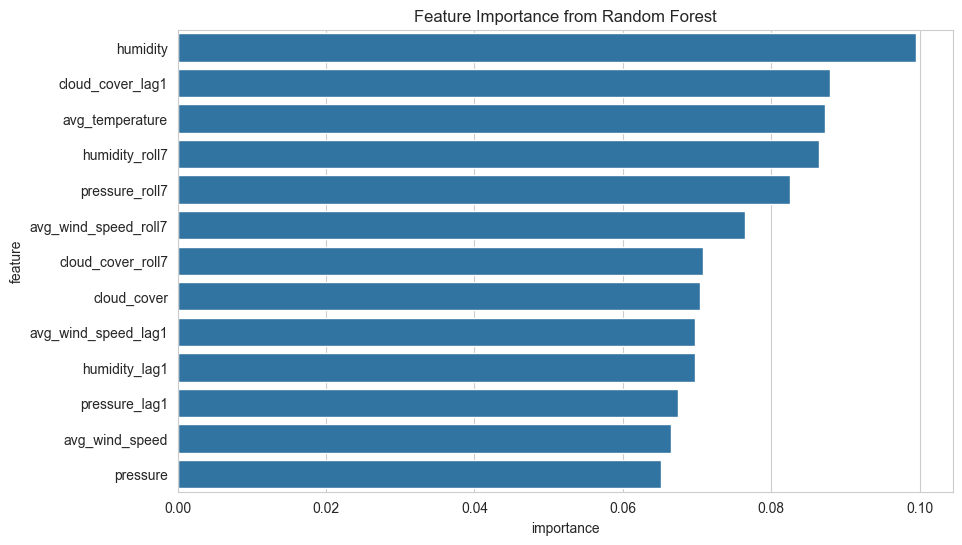

In [54]:
feature_cols=X.columns

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance from Random Forest')
plt.show()

Humidity is the strongest predictor of rain_or_not, which aligns with meteorological expectations (higher humidity often precedes rain) and our EDA (boxplot showed higher median humidity on rainy days, ~70% vs. 40%).

 The rolling and lagged features reinforce this by capturing both trends (humidity_roll7) and short-term changes (humidity_lag1).




## XGBoost, Logistic Regression & SVM

In [55]:
models = {
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=1.5),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
}


for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions (default threshold of 0.5)
    y_pred = model.predict(X_test_scaled)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))




XGBoost Results:
Accuracy: 0.6557377049180327
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.14      0.22        21
           1       0.67      0.93      0.78        40

    accuracy                           0.66        61
   macro avg       0.59      0.53      0.50        61
weighted avg       0.61      0.66      0.59        61


Logistic Regression Results:
Accuracy: 0.7213114754098361
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.38      0.48        21
           1       0.73      0.90      0.81        40

    accuracy                           0.72        61
   macro avg       0.70      0.64      0.65        61
weighted avg       0.71      0.72      0.70        61


SVM Results:
Accuracy: 0.7213114754098361
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.43      0.51        21
           1       

Logistic Regression:

    Best accuracy (0.7213) and highest recall for class 0 (0.38), with a balanced F1 (0.48 vs. 0.81).
    
This indicates a linear model might capture the relationship between features and rain better than trees in this case.

SVM:

    Matches Logistic Regression’s accuracy (0.7213) and has the highest recall for class 0 (0.43) and F1 (0.51), suggesting it handles the non-linear boundary well with the scaled data.

All models show a bias toward class 1 (rain) due to the imbalance (65.6% in test set), with recall for class 0 ranging from 0.14 to 0.43. Logistic Regression and SVM outperform others in balancing recall.

### Running the models with SMOTE

In [56]:
models = {
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=1.5),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
}


for name, model in models.items():
    # Train the model
    model.fit(X_train_smote, y_train_smote)

    # Make predictions (default threshold of 0.5)
    y_pred = model.predict(X_test_scaled)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))




XGBoost Results:
Accuracy: 0.6721311475409836
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.24      0.33        21
           1       0.69      0.90      0.78        40

    accuracy                           0.67        61
   macro avg       0.62      0.57      0.56        61
weighted avg       0.65      0.67      0.63        61


Logistic Regression Results:
Accuracy: 0.7049180327868853
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        21
           1       0.73      0.88      0.80        40

    accuracy                           0.70        61
   macro avg       0.67      0.63      0.63        61
weighted avg       0.69      0.70      0.68        61


SVM Results:
Accuracy: 0.7377049180327869
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.38      0.50        21
           1       

SVM with Oversampling is the top performer (0.7377 accuracy, 0.38 recall for class 0, 0.93 recall for class 1). Its ability to handle non-linear relationships and leverage oversampling makes it a strong choice.

In [57]:
# training and saving the svm model
svm = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
svm.fit(X_train_smote, y_train_smote)

y_pred_svm = model.predict(X_test_scaled)

print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm))


Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.73      0.38      0.50        21
           1       0.74      0.93      0.82        40

    accuracy                           0.74        61
   macro avg       0.73      0.65      0.66        61
weighted avg       0.74      0.74      0.71        61



## Hyperparameter Tuning

### SVM - Tuned

In [58]:
param_grid = [
    {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},  # No gamma for linear
    {'C': [0.1, 1, 10, 100], 'kernel': ['rbf'], 'gamma': ['scale', 'auto', 0.01, 0.1, 1]},
    {'C': [0.1, 1, 10, 100], 'kernel': ['poly'], 'gamma': ['scale', 'auto', 0.01, 0.1, 1], 'degree': [2, 3, 4]}
]

# Initialize SVM with class balancing
svm = SVC(probability=True, random_state=42, class_weight='balanced')

# Use StratifiedKFold to handle class imbalance better
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(svm, param_grid, cv=cv_strategy, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters and model
print("Best Hyperparameters:", grid_search.best_params_)
best_svm = grid_search.best_estimator_

Best Hyperparameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [59]:
y_pred_svm_tuned = best_svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_svm_tuned)
print("\nTuned SVM Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_tuned))


Tuned SVM Accuracy: 0.6065573770491803

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        21
           1       0.65      0.85      0.74        40

    accuracy                           0.61        61
   macro avg       0.49      0.50      0.47        61
weighted avg       0.54      0.61      0.55        61



### Logistic Regresion - Tuned

In [60]:
# Hyperparameter Tuning with GridSearchCV and Stratified K-Fold
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Range of regularization strength
    'penalty': ['l1', 'l2'],  # Types of regularization
    'solver': ['liblinear', 'saga']  # Solvers supporting l1 and l2
}
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=stratified_cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Best Model and Results
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Balanced Accuracy:", grid_search.best_score_)
best_log_reg = grid_search.best_estimator_

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Balanced Accuracy: 0.6806451612903226


In [61]:
# Evaluate on Test Set
y_pred_log_tuned = best_log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_log_tuned)
print("\nTuned Logistic Regression Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_tuned))


Tuned Logistic Regression Accuracy: 0.7704918032786885

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.43      0.56        21
           1       0.76      0.95      0.84        40

    accuracy                           0.77        61
   macro avg       0.79      0.69      0.70        61
weighted avg       0.78      0.77      0.75        61



after parameter tuning, we are seeing  that logistic regression outperform the SVM model.

## Final Predictions for the next 21 days

If we assign the same values for the 21 days and trying out to see if these predictions can be made with the means from the previous days. 

In [62]:
last_7_days = df_engineered.tail(7).copy()
# last_date = df_engineered.index[-1]
# future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=21, freq='D')

# # Create Future DataFrame with Assumed Values
# future_df = pd.DataFrame(index=future_dates, columns=X.columns)

# # Assume future values based on last 7 days' averages (adjust based on seasonal trends)
# future_df['avg_temperature'] = last_7_days['avg_temperature'].mean()  # e.g., ~20°C for Oct
# future_df['humidity'] = last_7_days['humidity'].mean() + 5  # Slight increase for wet season, e.g., ~60%
# future_df['avg_wind_speed'] = last_7_days['avg_wind_speed'].mean()  # e.g., ~7 km/h
# future_df['cloud_cover'] = last_7_days['cloud_cover'].mean() + 10  # Increase for potential rain, e.g., ~60%
# future_df['pressure'] = last_7_days['pressure'].mean()  # e.g., ~1013 hPa

# # Compute Lagged and Rolling Features for Future Data
# future_df['humidity_lag1'] = last_7_days['humidity'].iloc[-1]
# future_df['avg_wind_speed_lag1'] = last_7_days['avg_wind_speed'].iloc[-1]
# future_df['cloud_cover_lag1'] = last_7_days['cloud_cover'].iloc[-1]
# future_df['pressure_lag1'] = last_7_days['pressure'].iloc[-1]
# future_df['humidity_roll7'] = last_7_days['humidity'].mean()
# future_df['avg_wind_speed_roll7'] = last_7_days['avg_wind_speed'].mean()
# future_df['cloud_cover_roll7'] = last_7_days['cloud_cover'].mean()
# future_df['pressure_roll7'] = last_7_days['pressure'].mean()

In [63]:
# future_df.head()

In [64]:
# # Scale Future Data
# future_df_scaled = scaler.transform(future_df)

# # Predict Probabilities
# future_probabilities = best_log_reg.predict_proba(future_df_scaled)[:, 1]

# # Create Results DataFrame
# results_df = pd.DataFrame({
#     'Date': future_dates,
#     'Rain_Probability': future_probabilities
# })
# print("\n21-Day Rainfall Probability Forecast:")
# print(results_df)

# # Plot Probabilities
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(results_df['Date'], results_df['Rain_Probability'], marker='o')
# plt.title('21-Day Rainfall Probability Forecast')
# plt.xlabel('Date')
# plt.ylabel('Probability of Rain')
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.ylim(0, 1)
# plt.show()

the future DataFrame (future_df) has the same feature values for all 21 days because we’re using constant averages from the last 7 days for all features (e.g., avg_temperature, humidity, humidity_roll7).

 Since Logistic Regression (or any model) bases predictions on feature values, identical inputs lead to identical outputs—hence the constant 0.306783 probability.

Thus this approach doesn't work so we'll have to introduce some realistic randomness.


#### Final Prediction Probabilities

since we don't have the data for the next 21 days and also we don't have very less autocorrelation, our solution in this case would be to come up with weather data based on the last 7 days. 

In [65]:
# Prepare Last 7 Days for Rolling Features
last_7_days = df_engineered.tail(7).copy()
last_date = df_engineered.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=21, freq='D')

# Initialize Future DataFrame and Buffer
future_data = []
last_7_days_values = last_7_days.copy()  # Start with last 7 historical days

# Simulate daily weather variations (e.g., slight fluctuations)
np.random.seed(42)  # For reproducibility
for i in range(21):
    day_data = {}
    day_data['avg_temperature'] = last_7_days['avg_temperature'].mean() + np.random.uniform(-2, 2)  # ±1°C
    day_data['humidity'] = min(80, last_7_days['humidity'].mean() + 5 + np.random.uniform(-2, 2))  # 70-80%
    day_data['avg_wind_speed'] = last_7_days['avg_wind_speed'].mean() + np.random.uniform(-0.5, 0.5)  # ±0.5 km/h
    day_data['cloud_cover'] = min(90, last_7_days['cloud_cover'].mean() + 10 + np.random.uniform(-5, 5))  # 80-90%
    day_data['pressure'] = last_7_days['pressure'].mean() + np.random.uniform(-5, 5)  # ±1 hPa

    # Append current day's data to buffer
    new_row = pd.DataFrame([day_data], index=[future_dates[i]])
    last_7_days_values = pd.concat([last_7_days_values, new_row]).tail(14)  # Keep last 14 rows (7 historical + 7 predicted)

    # Compute Lagged and Rolling Features
    if i == 0:
        # For the first day, use last 7 days' last value for lag1
        day_data['humidity_lag1'] = last_7_days['humidity'].iloc[-1]
        day_data['avg_wind_speed_lag1'] = last_7_days['avg_wind_speed'].iloc[-1]
        day_data['cloud_cover_lag1'] = last_7_days['cloud_cover'].iloc[-1]
        day_data['pressure_lag1'] = last_7_days['pressure'].iloc[-1]
    else:
        # Use the previous day's value for lag1
        day_data['humidity_lag1'] = last_7_days_values['humidity'].iloc[-2]
        day_data['avg_wind_speed_lag1'] = last_7_days_values['avg_wind_speed'].iloc[-2]
        day_data['cloud_cover_lag1'] = last_7_days_values['cloud_cover'].iloc[-2]
        day_data['pressure_lag1'] = last_7_days_values['pressure'].iloc[-2]

    # Rolling features (use at least 7 or 5 rows)
    day_data['humidity_roll7'] = last_7_days_values['humidity'].tail(7).mean()
    day_data['avg_wind_speed_roll7'] = last_7_days_values['avg_wind_speed'].tail(7).mean()
    day_data['cloud_cover_roll7'] = last_7_days_values['cloud_cover'].tail(5).mean()
    day_data['pressure_roll7'] = last_7_days_values['pressure'].tail(5).mean()

    future_data.append(day_data)


In [66]:
# Create Future DataFrame with all expected columns
future_df = pd.DataFrame(future_data, index=future_dates, columns=X.columns)
future_df.head()

,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure,humidity_lag1,avg_wind_speed_lag1,cloud_cover_lag1,pressure_lag1,humidity_roll7,avg_wind_speed_roll7,cloud_cover_roll7,pressure_roll7
2023-11-08,21.714371,46.034701,7.475433,55.925727,983.698948,37.717416,9.388371,25.929676,983.134701,39.642031,6.758287,51.520752,991.134152
2023-11-09,20.840188,42.464179,7.609616,55.950292,989.219487,46.034701,7.475433,55.925727,983.698948,39.593474,7.705326,52.349235,996.177567
2023-11-10,20.298548,46.111483,7.575882,52.062533,983.957011,42.464179,7.609616,55.950292,989.219487,40.786984,8.111972,56.787231,997.432683
2023-11-11,20.949828,43.448813,7.268196,54.258592,985.051053,46.111483,7.575882,52.062533,983.957011,40.966729,7.994233,48.825364,985.012240
2023-11-12,22.663622,42.789820,7.035584,53.602761,986.699461,43.448813,7.268196,54.258592,985.051053,41.907344,7.304910,54.359981,985.725192



21-Day Rainfall Probability Forecast:
         Date  Rain_Probability
0  2023-11-08          0.360430
1  2023-11-09          0.361489
2  2023-11-10          0.390832
3  2023-11-11          0.275853
4  2023-11-12          0.283497
5  2023-11-13          0.286163
6  2023-11-14          0.287331
7  2023-11-15          0.293407
8  2023-11-16          0.299419
9  2023-11-17          0.294118
10 2023-11-18          0.318694
11 2023-11-19          0.284006
12 2023-11-20          0.297721
13 2023-11-21          0.299556
14 2023-11-22          0.308029
15 2023-11-23          0.304868
16 2023-11-24          0.312585
17 2023-11-25          0.322366
18 2023-11-26          0.309055
19 2023-11-27          0.296400
20 2023-11-28          0.318448


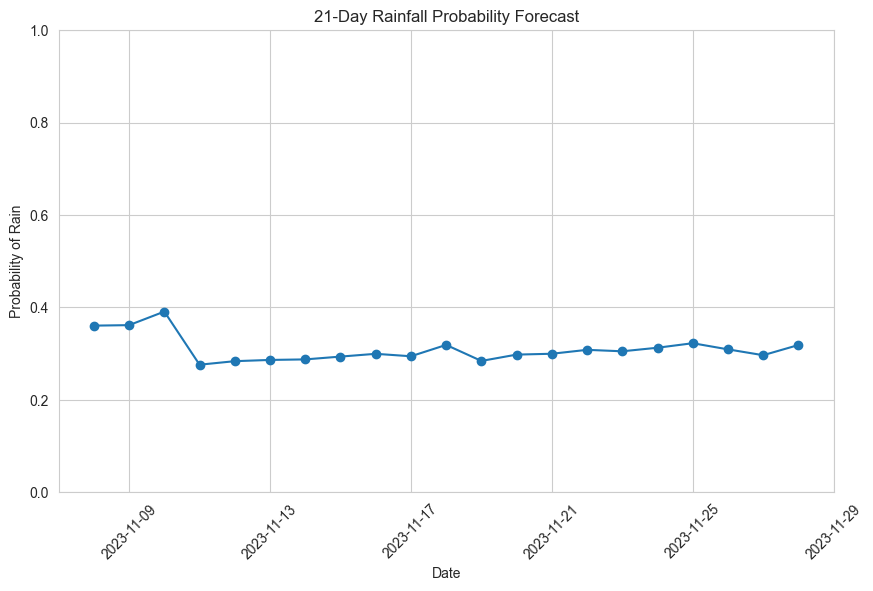

In [67]:
# Ensure all columns are present and in the correct order
for col in X.columns:
    if col not in future_df.columns:
        future_df[col] = 0  # Default to 0 if missing (shouldn't happen)

# Scale Future Data
try:
    future_df_scaled = scaler.transform(future_df)
except ValueError as e:
    print(f"Scaling Error: {e}")
    print("Future_df columns:", future_df.columns.tolist())
    print("X_train columns:", X.columns.tolist())
    raise

# Predict Probabilities
future_probabilities = best_log_reg.predict_proba(future_df_scaled)[:, 1]

# Create Results DataFrame
results_df = pd.DataFrame({
    'Date': future_dates,
    'Rain_Probability': future_probabilities
})
print("\n21-Day Rainfall Probability Forecast:")
print(results_df)

# Plot Probabilities
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Rain_Probability'], marker='o')
plt.title('21-Day Rainfall Probability Forecast')
plt.xlabel('Date')
plt.ylabel('Probability of Rain')
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

# Time series Modelling

Trying out time series models

In [68]:
from statsmodels.tsa.stattools import adfuller

# Test for stationarity
result = adfuller(df_engineered['rain_or_not'])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

ADF Statistic: -5.720018
p-value: 0.000001


    Stationarity: A time series is stationary if its statistical properties (mean, variance) do not change over time. Non-stationary data can lead to unreliable statistical inferences.

    Unit Root: A unit root in a time series indicates that shocks to the system can have permanent effects, leading to non-stationarity.

Steps of the ADF Test

    Hypotheses:
        Null Hypothesis (H0): The time series has a unit root (is non-stationary).
        Alternative Hypothesis (H1): The time series is stationary (does not have a unit root).

 The ADF statistic is a negative value, and a more negative value indicates stronger evidence against the null hypothesis. the P value also stays at a very low number making us reject the null hypothesis.


### Prophet

08:08:05 - cmdstanpy - INFO - Chain [1] start processing
08:08:06 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2023-01-07  0.710961    0.095399    1.330062
1   2023-01-08  0.758719    0.121829    1.307935
2   2023-01-09  0.616051   -0.022858    1.222490
3   2023-01-10  0.782826    0.115141    1.381778
4   2023-01-11  0.797186    0.169299    1.425913
..         ...       ...         ...         ...
321 2023-11-24  0.500434   -0.101375    1.131679
322 2023-11-25  0.506839   -0.089701    1.136058
323 2023-11-26  0.554615   -0.017094    1.131610
324 2023-11-27  0.411964   -0.196141    1.041986
325 2023-11-28  0.578756   -0.050154    1.153928

[326 rows x 4 columns]


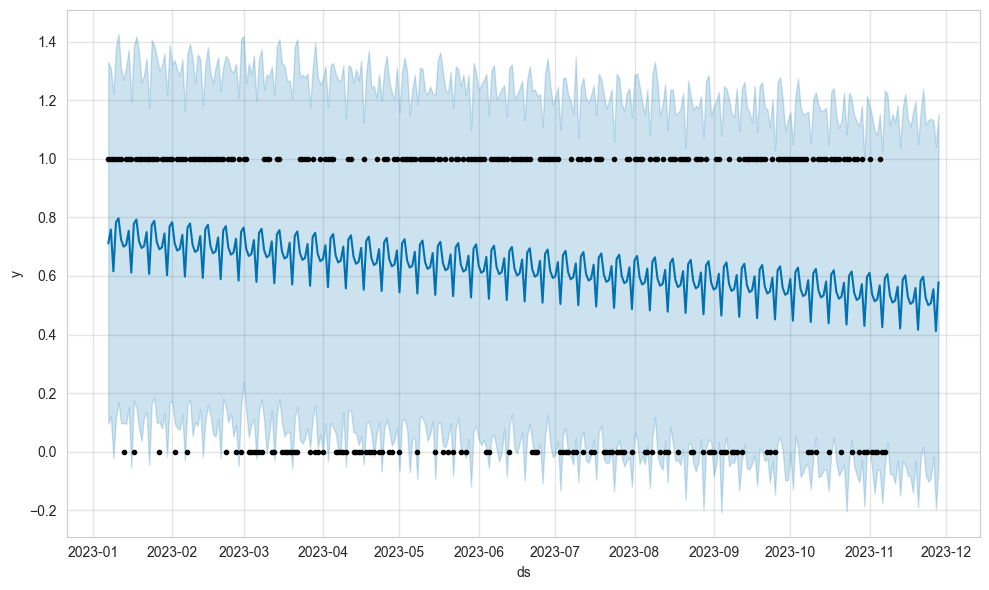

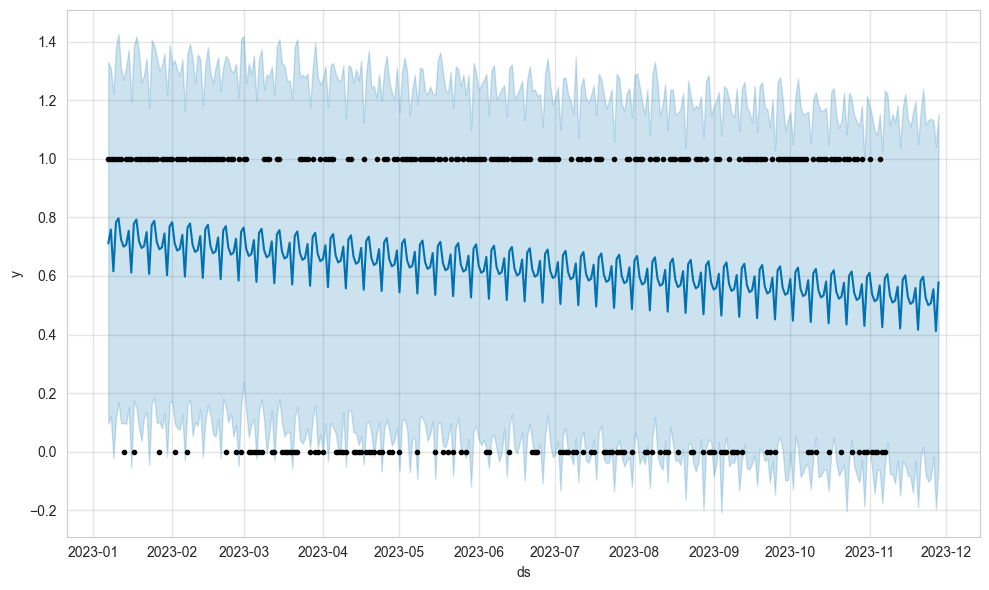

In [ ]:
# Reset index for df_engineered if needed
df_reset = df_engineered.reset_index()

# Select relevant columns (Date and rainfall data)
df = df_reset[['date', 'rain_or_not']].copy()

# Rename the columns for Prophet compatibility
df.columns = ['ds', 'y']  # 'ds' for dates, 'y' for the target variable

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(df)

# Create future dataframe for the next 30 days
future = model.make_future_dataframe(periods=21)  

# Make predictions
forecast = model.predict(future)

# View the forecast results
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Plot the results
model.plot(forecast)


In [70]:
forecast[['ds', 'yhat']].tail(21)

,ds,yhat
305,2023-11-08,0.606369
306,2023-11-09,0.533448
307,2023-11-10,0.509258
308,2023-11-11,0.515663
309,2023-11-12,0.563439
310,2023-11-13,0.420788
311,2023-11-14,0.587580
312,2023-11-15,0.601957
313,2023-11-16,0.529036
314,2023-11-17,0.504846


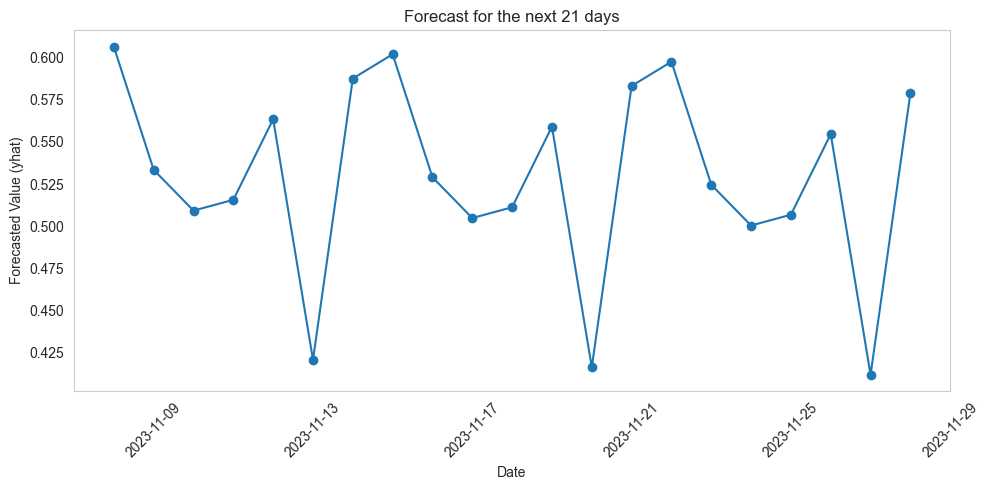

In [71]:
data_to_plot = forecast[['ds', 'yhat']].tail(21)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data_to_plot['ds'], data_to_plot['yhat'], marker='o')
plt.title('Forecast for the next 21 days')
plt.xlabel('Date')
plt.ylabel('Forecasted Value (yhat)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

enabling weekly seasonality

08:04:01 - cmdstanpy - INFO - Chain [1] start processing
08:04:01 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2023-01-07  0.710961    0.087848    1.317372
1   2023-01-08  0.758719    0.141189    1.351453
2   2023-01-09  0.616051    0.015139    1.206726
3   2023-01-10  0.782826    0.145271    1.386176
4   2023-01-11  0.797186    0.201836    1.414123
..         ...       ...         ...         ...
321 2023-11-24  0.500434   -0.121731    1.136732
322 2023-11-25  0.506839   -0.118191    1.119418
323 2023-11-26  0.554615   -0.034960    1.154327
324 2023-11-27  0.411964   -0.232434    1.038196
325 2023-11-28  0.578756   -0.072915    1.178571

[326 rows x 4 columns]


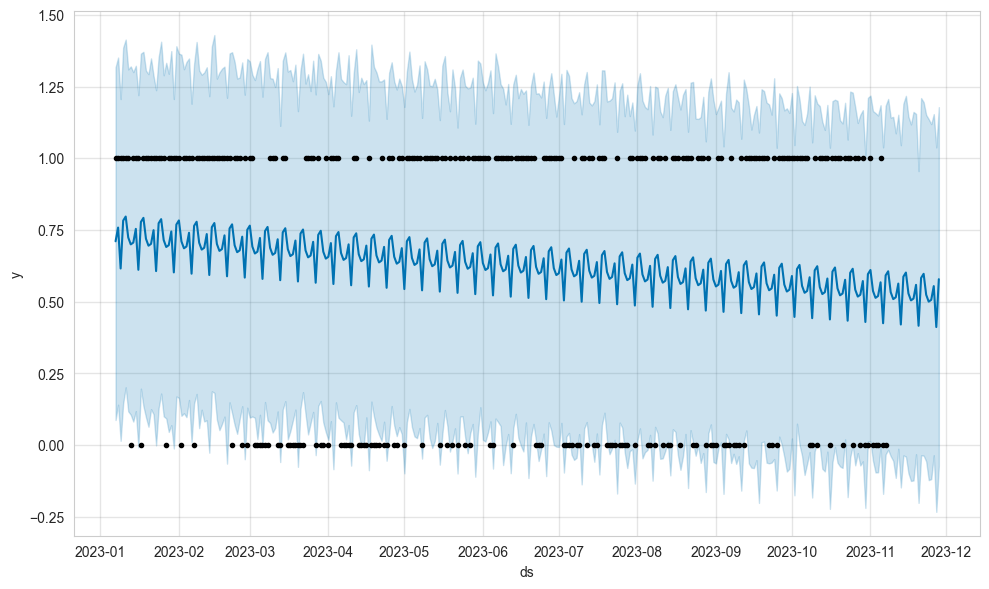

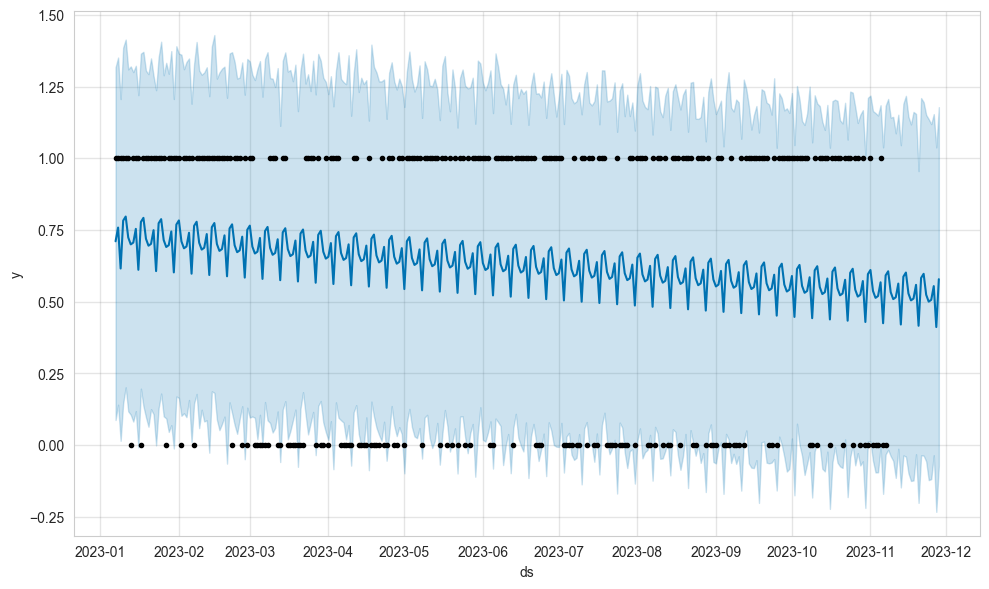

In [72]:
model = Prophet(
    weekly_seasonality=True
)

# Fit the model
model.fit(df)

# Create future dataframe for the next 30 days
future = model.make_future_dataframe(periods=21)  

# Make predictions
forecast = model.predict(future)

# View the forecast results
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Plot the results
model.plot(forecast)


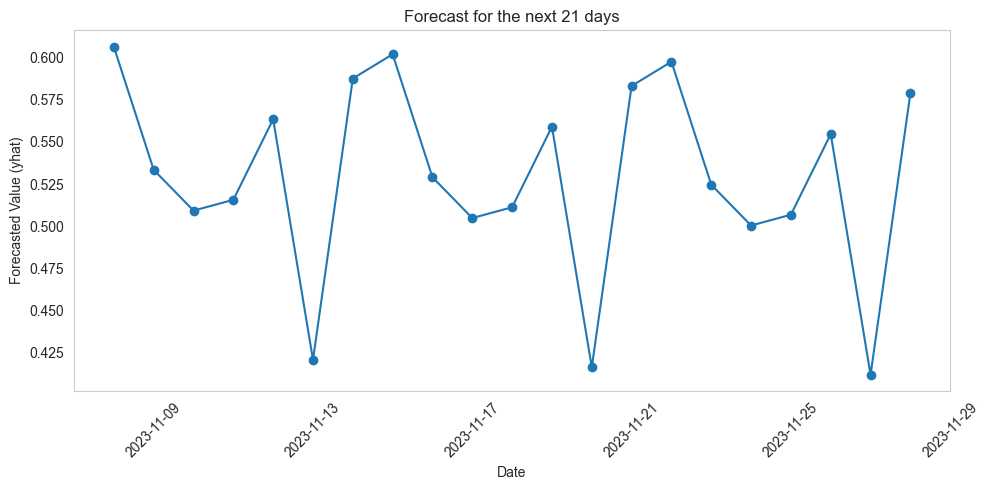

In [73]:
data_to_plot = forecast[['ds', 'yhat']].tail(21)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data_to_plot['ds'], data_to_plot['yhat'], marker='o')
plt.title('Forecast for the next 21 days')
plt.xlabel('Date')
plt.ylabel('Forecasted Value (yhat)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

rolling the values of daily records to a weekly level granularity cuz what we have is a binary output. Prophet model expects continues targets. so we're changing the granularity of the data. 


08:10:26 - cmdstanpy - INFO - Chain [1] start processing
08:10:26 - cmdstanpy - INFO - Chain [1] done processing


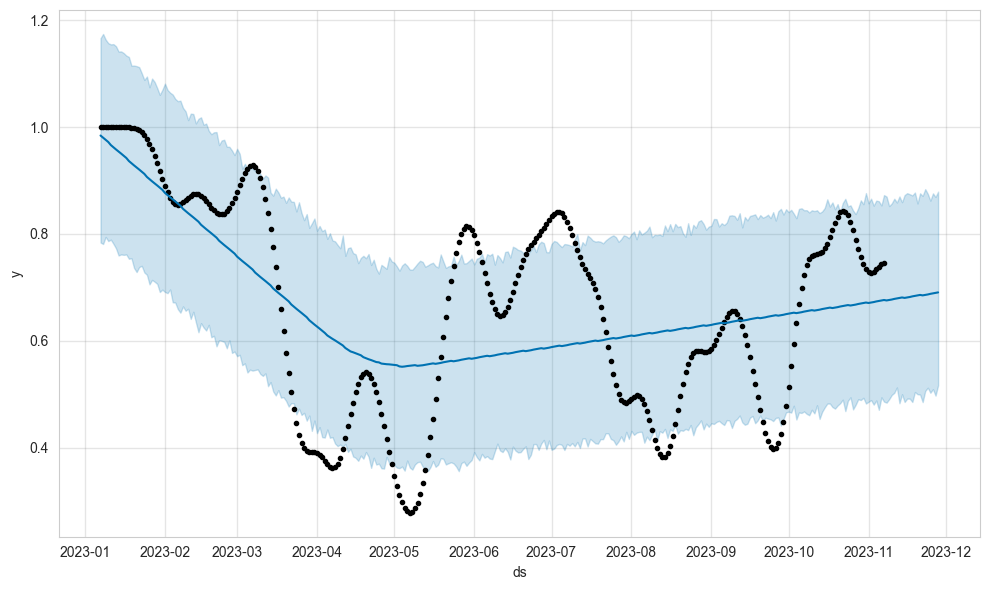

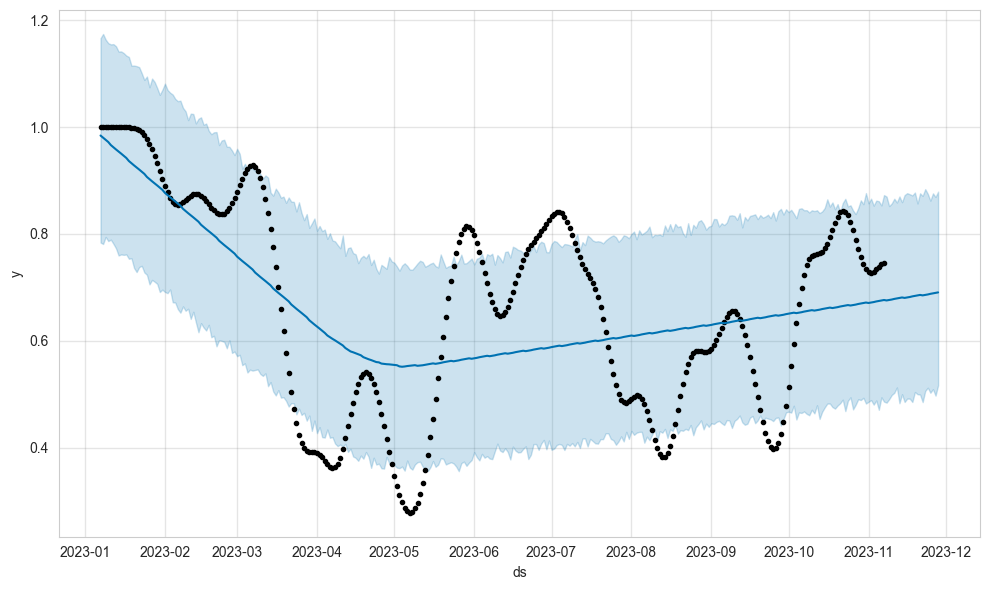

In [91]:
df['y'] = df['y'].rolling(window=7, min_periods=1).mean()

model = Prophet()

# Fit the model
model.fit(df)

# Create future dataframe for the next 30 days
future = model.make_future_dataframe(periods=21)  

# Make predictions
forecast = model.predict(future)

# View the forecast results
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Plot the results
model.plot(forecast)


min Periods:

    min_periods=1 means the rolling mean will be calculated even if the window has fewer than 7 values at the start of the dataset (e.g., for the first 6 days, it uses 1, 2, 3, ..., up to 6 values). Without this, the first 6 values would be NaN.

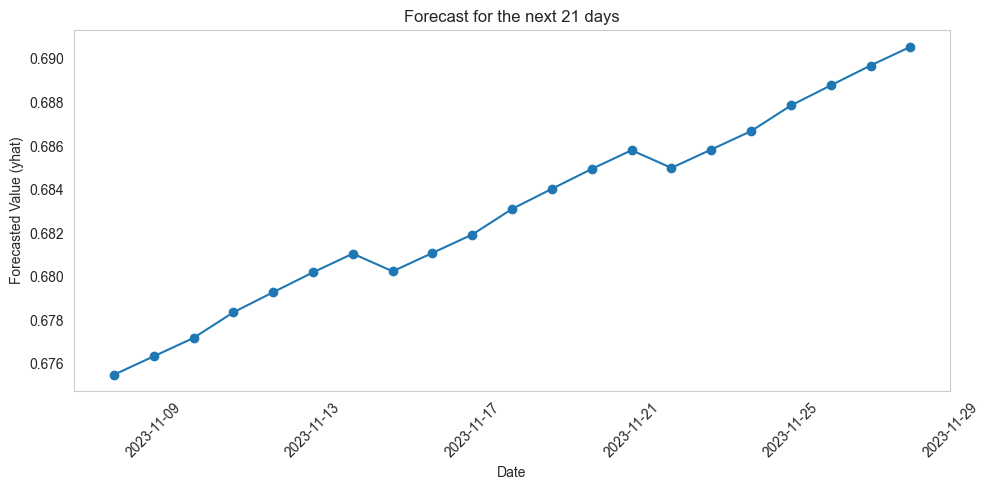

In [92]:
data_to_plot = forecast[['ds', 'yhat']].tail(21)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data_to_plot['ds'], data_to_plot['yhat'], marker='o')
plt.title('Forecast for the next 21 days')
plt.xlabel('Date')
plt.ylabel('Forecasted Value (yhat)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

enabling some seasonality metrics to go along the trends we see in humidity and rainfall patterns.

yearly and weekly seasonality cannot be applied here...

by adding custom 4-month seasonality, Prophet will now look for patterns that repeat approximately every 120 days across your dataset. This means it will try to capture trends that occur within each 4-month cycle


08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] done processing


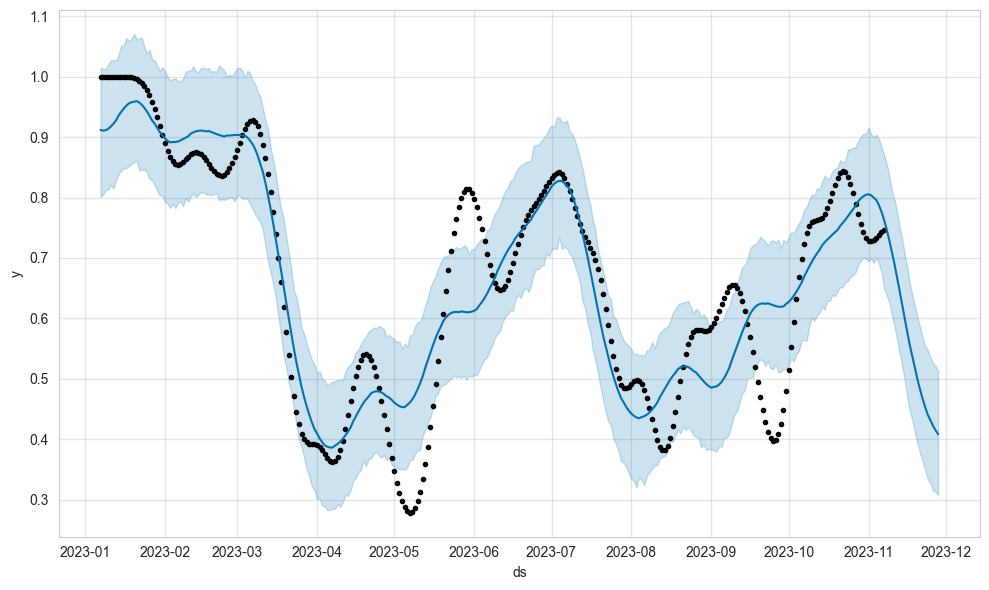

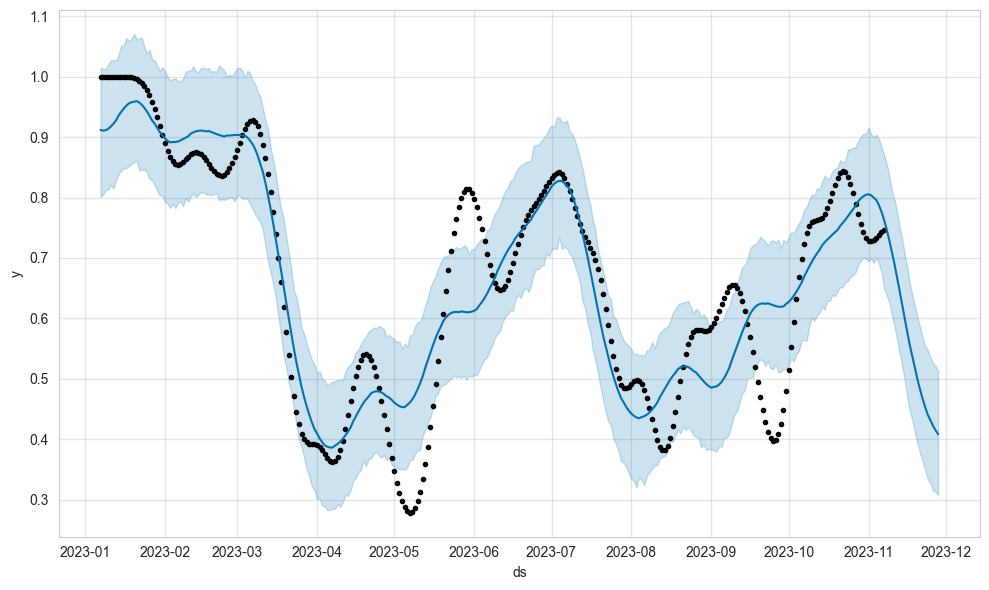

In [93]:
# Apply rolling mean smoothing
# df['y'] = df['y'].rolling(window=7, min_periods=1).mean()

# Initialize the model
model = Prophet()

# Add custom 4-month seasonality (120 days)
model.add_seasonality(name='four_months', period=120, fourier_order=5)

# Fit the model
model.fit(df)

# Create future dataframe for the next 21 days
future = model.make_future_dataframe(periods=21)

# Make predictions
forecast = model.predict(future)

# Plot the results
model.plot(forecast)


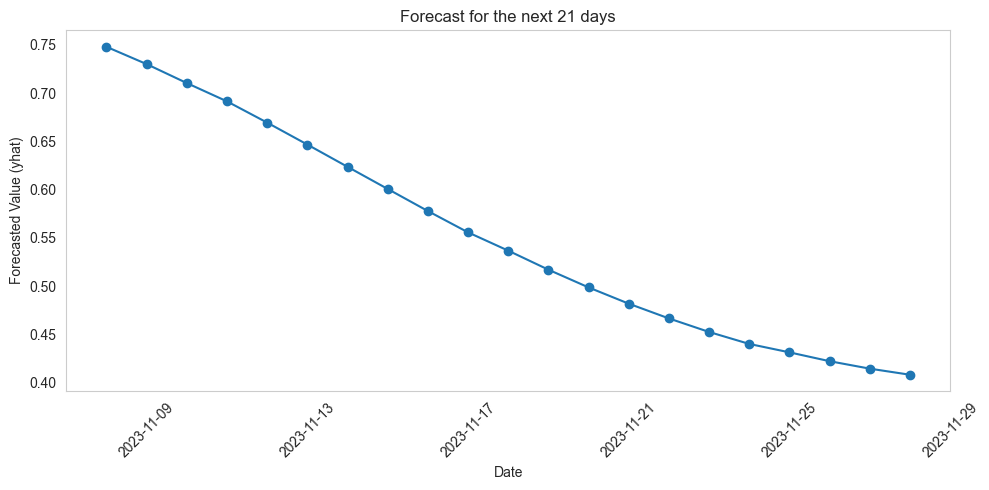

In [94]:
data_to_plot = forecast[['ds', 'yhat']].tail(21)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data_to_plot['ds'], data_to_plot['yhat'], marker='o')
plt.title('Forecast for the next 21 days')
plt.xlabel('Date')
plt.ylabel('Forecasted Value (yhat)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

with regressors

In [78]:

# Reset index for df_engineered if needed
df_reset = df_engineered.reset_index()

# Select relevant columns (Date, rainfall data, and weather features)
regressors = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']
df = df_reset[['date', 'rain_or_not'] + regressors].copy()

# Rename the columns for Prophet compatibility
df.columns = ['ds', 'y'] + regressors  # 'ds' for dates, 'y' for the target variable

print(df.head())
print(df.isna().sum())



          ds  y  avg_temperature   humidity  avg_wind_speed  cloud_cover  \
0 2023-01-07  1        23.671006  63.997418        5.654166    86.805669   
1 2023-01-08  1        32.245441  67.083073        6.940197    80.592540   
2 2023-01-09  1        30.078517  64.088581        4.520668    79.003044   
3 2023-01-10  1        31.620631  71.876470       11.214141    30.467914   
4 2023-01-11  1        25.205845  58.365841       14.810780     8.091928   

      pressure  
0   998.296887  
1   963.347997  
2   958.060151  
3  1022.793931  
4   999.646115  
ds                 0
y                  0
avg_temperature    0
humidity           0
avg_wind_speed     0
cloud_cover        0
pressure           0
dtype: int64


In [79]:
# Use a dictionary to scale each regressor independently
scalers = {regressor: StandardScaler() for regressor in regressors}
df_scaled = df.copy()
for regressor in regressors:
    df_scaled[regressor] = scalers[regressor].fit_transform(df[[regressor]])

# Step 2: Split Data for Validation (Optional but Recommended)
# Use the last 30 days for validation
train_df = df_scaled[:-30]
val_df = df_scaled[-30:]

# Step 3: Initialize and Train the Prophet Model
model = Prophet()


for regressor in regressors:
    model.add_regressor(regressor)
model.fit(train_df)



08:04:08 - cmdstanpy - INFO - Chain [1] start processing
08:04:09 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
train_df

,ds,y,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure
0,2023-01-07,1,-0.351597,0.457296,-0.384731,1.304019,-0.089838
1,2023-01-08,1,0.907966,0.618155,-0.084238,1.085203,-1.302465
2,2023-01-09,1,0.589650,0.462048,-0.649583,1.029224,-1.485938
3,2023-01-10,1,0.816183,0.868041,0.914410,-0.680100,0.760139
4,2023-01-11,1,-0.126134,0.163714,1.754799,-1.468143,-0.043024
...,...,...,...,...,...,...,...
270,2023-10-04,1,1.312603,1.458183,0.009501,1.011145,1.111786
271,2023-10-05,1,1.312603,0.989104,-0.930565,0.739203,1.284203
272,2023-10-06,1,1.312603,1.009167,1.754799,1.024239,0.218284
273,2023-10-07,1,1.312603,1.082045,0.094048,0.410709,0.029789


In [81]:
val_future = val_df[['ds'] + regressors].copy()  # Use validation data directly
val_forecast = model.predict(val_future)
val_forecast['yhat_binary'] = (val_forecast['yhat'] > 0.5).astype(int)
val_accuracy = accuracy_score(val_df['y'], val_forecast['yhat_binary'])
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Step 5: Predict Future Regressor Values for the Next 21 Days
future_dates = pd.date_range(start=df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=21, freq='D')
future_df = pd.DataFrame({'ds': future_dates})

# Use Prophet to predict each regressor
for regressor in regressors:
    df_reg = df[['ds', regressor]].rename(columns={regressor: 'y'})
    model_reg = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_reg.fit(df_reg)
    future_reg = model_reg.make_future_dataframe(periods=21)
    forecast_reg = model_reg.predict(future_reg)
    future_values = forecast_reg.tail(21)['yhat'].values.reshape(-1, 1)
    future_df[regressor] = scalers[regressor].transform(future_values)

future_df

Validation Accuracy: 0.6000


08:04:09 - cmdstanpy - INFO - Chain [1] start processing
08:04:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Data Projects\Agri-timeseries\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
08:04:10 - cmdstanpy - INFO - Chain [1] start processing
08:04:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Data Projects\Agri-timeseries\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
08:04:11 - cmdstanpy - INFO - Chain [1] start processing
08:04:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Data Projects\Agri-timeseries\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
08:04:12 - cmdstanpy - INFO - Chain [1] 

,ds,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure
0,2023-11-08,-0.736310,-1.052550,0.056099,-0.836218,-0.366932
1,2023-11-09,-0.658142,-1.191680,0.194026,-0.601046,-0.105980
2,2023-11-10,-0.924795,-1.239382,-0.010828,-0.537772,-0.397305
3,2023-11-11,-0.789290,-1.272049,0.099472,-0.630678,-0.441591
4,2023-11-12,-0.772844,-1.281423,-0.038640,-0.863288,-0.170432
5,2023-11-13,-0.780776,-1.316177,0.083680,-0.802310,-0.006674
6,2023-11-14,-0.689384,-1.329884,0.091199,-0.677996,-0.226630
7,2023-11-15,-0.734211,-1.411405,0.423139,-0.997240,0.010465
8,2023-11-16,-0.620627,-1.517672,0.568593,-0.744455,0.313024
9,2023-11-17,-0.853950,-1.529583,0.364467,-0.664647,0.055815



Forecast for the Next 21 Days:
           ds      yhat
0  2023-11-08  0.477064
1  2023-11-09  0.354597
2  2023-11-10  0.326882
3  2023-11-11  0.375302
4  2023-11-12  0.347286
5  2023-11-13  0.280941
6  2023-11-14  0.406623
7  2023-11-15  0.425879
8  2023-11-16  0.310314
9  2023-11-17  0.289700
10 2023-11-18  0.345395
11 2023-11-19  0.324799
12 2023-11-20  0.265986
13 2023-11-21  0.399273
14 2023-11-22  0.426162
15 2023-11-23  0.318209
16 2023-11-24  0.305133
17 2023-11-25  0.368228
18 2023-11-26  0.354827
19 2023-11-27  0.302935
20 2023-11-28  0.442793


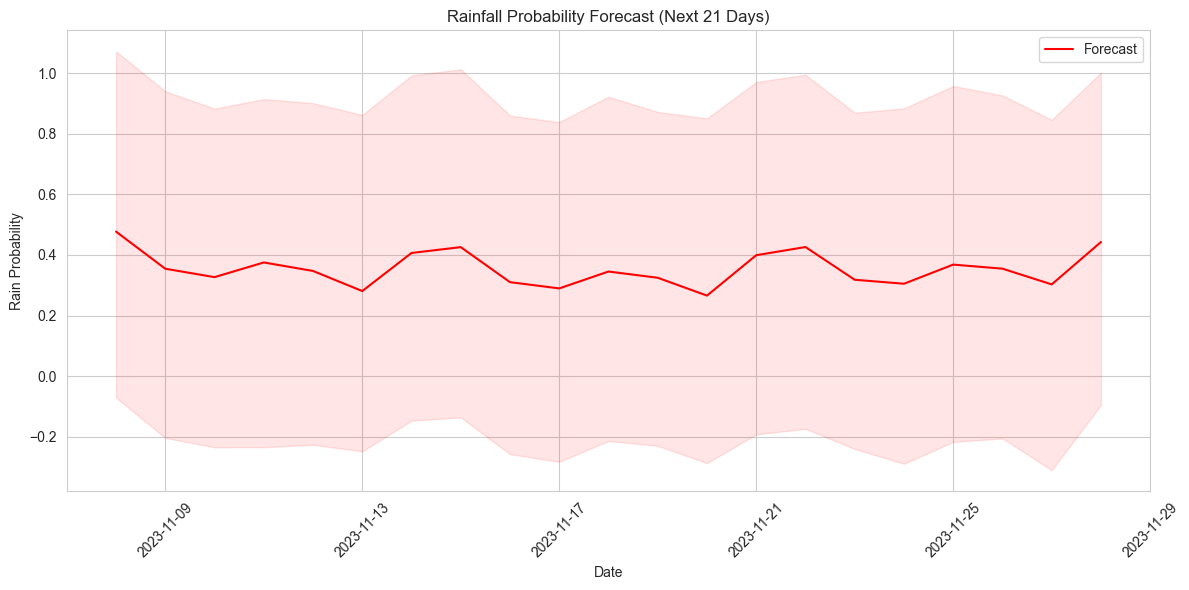

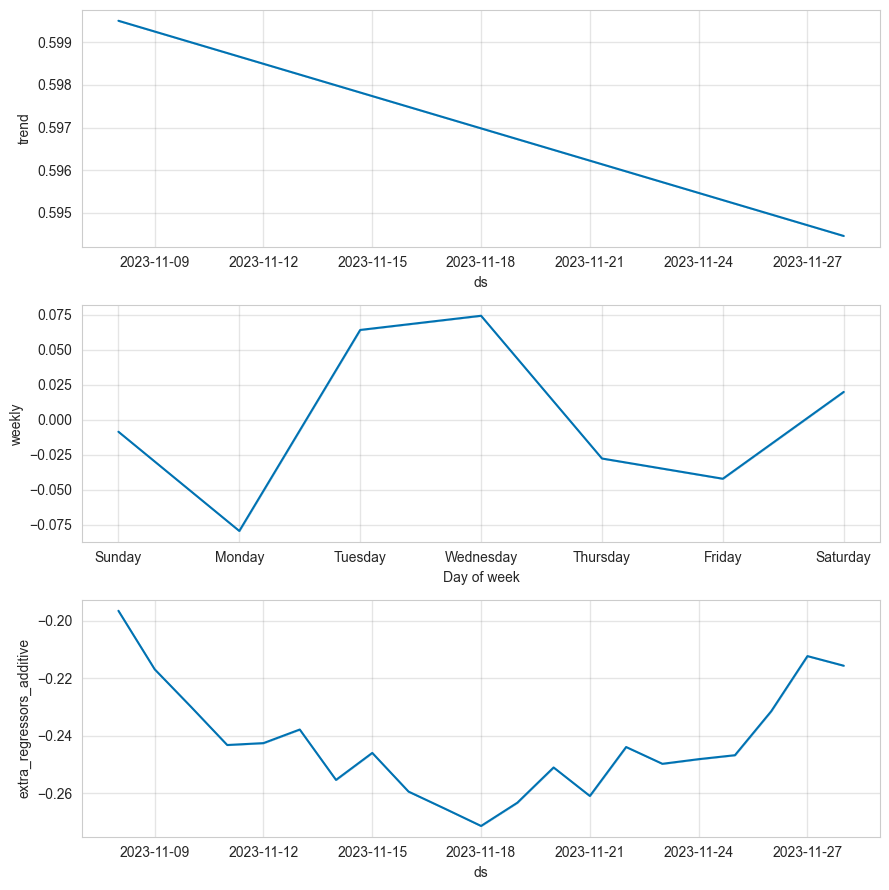

In [82]:
# Forecast Rainfall for the Next 21 Days
forecast = model.predict(future_df)

# Step 7: View and Visualize Results
future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the forecast
print("\nForecast for the Next 21 Days:")
print(future_forecast[['ds', 'yhat']])

# Plot the results (only forecast, no historical data)
plt.figure(figsize=(12, 6))
plt.plot(future_forecast['ds'], future_forecast['yhat'], 'r-', label='Forecast')
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='r', alpha=0.1)
plt.title('Rainfall Probability Forecast (Next 21 Days)')
plt.xlabel('Date')
plt.ylabel('Rain Probability')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Plot components (trend, seasonality) for the forecast period
model.plot_components(forecast)
plt.show()